In [1]:
%%bash
hostname

brewer


In [44]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from mpl_toolkits.basemap import Basemap

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn

import matplotlib.animation as animation

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

# Train quick ridge regression model on ATom data

In [4]:
atom1_data_with_p = pd.read_csv('/home/shmh4/Downloads/atom1_key_species_photolysis_data_withP_T_G_ALT')

In [107]:
atom1_key_data = atom1_data_with_p[['OH_ATHOS', 'H2O_DLH', 'CH4_NOAA', 'CO_NOAA', 'NO2_CL', 'O3_CL', 'P', 
                                    'T', 'jO3_O2_O1D_CAFS', 'jNO2_NO_O3P_CAFS']]

In [108]:
atom1_key_data

OH_ATHOS     H2O_DLH  CH4_NOAA   CO_NOAA    NO2_CL    O3_CL        P  \
0          0.033  14481.3750  1857.670   65.6200  0.137210  14.1900  971.060   
1          0.033  14469.1625  1858.330   69.1800  0.135045  14.1430  971.300   
2          0.033  14456.9500  1858.990   72.7400  0.132880  14.0960  971.540   
3          0.033  14486.2550  1859.175   71.8075  0.126100  14.1320  971.830   
4          0.033  14515.5600  1859.360   70.8750  0.119320  14.1680  972.120   
...          ...         ...       ...       ...       ...      ...      ...   
221412     0.156  21538.2300  1888.280   97.9800  0.105910  21.7190  996.180   
221413     0.156  21493.8600  1888.900   95.6700  0.119190  21.7725  996.320   
221414     0.156  21449.4900  1889.520   93.3600  0.132470  21.8260  996.460   
221415     0.156  21385.1550  1890.125  101.9450  0.170770  21.8350  996.605   
221416     0.156  21320.8200  1890.730  110.5300  0.209070  21.8440  996.750   

             T  jO3_O2_O1D_CAFS  jNO2_NO_O3P_CAFS  
0       286.10         0.000004          0.001899  
1       286.35         0.000004          0.001897  
2       286.60         0.000004          0.001896  
3       286.60         0.000004          0.001894  
4       286.60         0.000004          0.001892  
...        ...              ...               ...  
221412  298.51         0.000023          0.008666  
221413  298.61         0.000023          0.008669  
221414  298.71         0.000023          0.008672  
221415  298.77         0.000023          0.008690  
221416  298.83         0.000023          0.008709  

[221417 rows x 10 columns]

In [ ]:
### Calculate OH mean and standard deviation for use later.

In [139]:
OH_mean = atom1_key_data.mean()[0]
OH_mean

0.18708638903062094

In [138]:
OH_std = atom1_key_data.std()[0]
OH_std

0.22123271214725962

In [115]:
### Normalise the dataset

In [113]:
normalised_key_atom1_data = (atom1_key_data - atom1_key_data.mean()) / atom1_key_data.std()

In [114]:
normalised_key_atom1_data

OH_ATHOS   H2O_DLH  CH4_NOAA   CO_NOAA    NO2_CL     O3_CL         P  \
0      -0.696490  1.861055  0.821655 -0.432718  1.606353 -1.157352  1.863852   
1      -0.696490  1.859035  0.842557 -0.306461  1.574038 -1.158623  1.864758   
2      -0.696490  1.857015  0.863459 -0.180205  1.541723 -1.159895  1.865665   
3      -0.696490  1.861862  0.869318 -0.213276  1.440525 -1.158921  1.866760   
4      -0.696490  1.866709  0.875177 -0.246348  1.339327 -1.157947  1.867854   
...          ...       ...       ...       ...       ...       ...       ...   
221412 -0.140514  3.028325  1.791067  0.714938  1.139170 -0.953670  1.958696   
221413 -0.140514  3.020985  1.810703  0.633013  1.337387 -0.952222  1.959225   
221414 -0.140514  3.013646  1.830338  0.551088  1.535604 -0.950775  1.959753   
221415 -0.140514  3.003005  1.849498  0.855557  2.107269 -0.950532  1.960301   
221416 -0.140514  2.992363  1.868658  1.160026  2.678933 -0.950288  1.960848   

               T  jO3_O2_O1D_CAFS  jNO2_NO_O3P_CAFS  
0       1.370637        -0.875211         -1.114259  
1       1.379210        -0.875210         -1.114532  
2       1.387783        -0.875209         -1.114806  
3       1.387783        -0.875208         -1.115079  
4       1.387783        -0.875207         -1.115353  
...          ...              ...               ...  
221412  1.796194        -0.060391          0.071606  
221413  1.799623        -0.060284          0.072176  
221414  1.803052        -0.060177          0.072746  
221415  1.805110        -0.059221          0.075965  
221416  1.807167        -0.058265          0.079185  

[221417 rows x 10 columns]

In [8]:
### Split data into training and testing data manually

In [9]:
train_OH_ATHOS = normalised_key_atom1_data.iloc[np.r_[185000:188285, 195485:221417], 0]
test_OH_ATHOS = normalised_key_atom1_data.iloc[188285:195485, 0]
train_data = normalised_key_atom1_data.iloc[np.r_[185000:188285, 195485:221417], 1:11]
test_data = normalised_key_atom1_data.iloc[188285:195485, 1:11]

In [10]:
### Split data using k-fold 

In [11]:
OH_data = normalised_key_atom1_data.iloc[185000:221417, 0]
other_data = normalised_key_atom1_data.iloc[185000:221417, 1:11]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(other_data, OH_data, test_size=0.4, random_state=0)

In [13]:
rr = Ridge(alpha=1e-2, fit_intercept=False)
rr.fit(X_train,y_train)

Ridge(alpha=0.01, fit_intercept=False)

In [14]:
rr.get_params()

{'alpha': 0.01,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [15]:
rr.coef_

array([ 0.25108994,  0.31849412,  0.16192909,  0.37956047,  0.0609911 ,
       -0.4915139 , -0.24515337,  0.19122984,  0.9351133 ])

In [16]:
predictions = rr.predict(X_test)

(-2.0, 9.0)

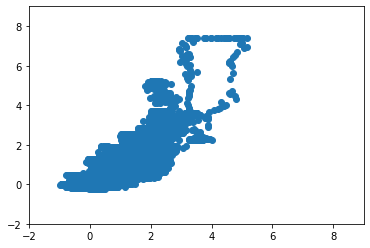

In [17]:
plt.scatter(predictions, y_test)
plt.xlim([-2, 9])
plt.ylim([-2, 9])

(5000.0, 5100.0)

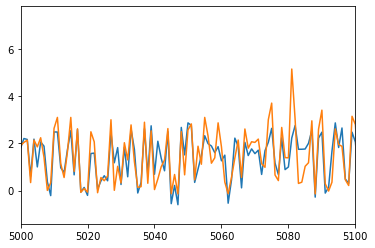

In [18]:
plt.plot(predictions)
plt.plot(np.arange(0,14567,1), y_test)
plt.xlim(5000,5100)

# Plot coefficients of the RR model

In [19]:
coefs = pd.DataFrame(rr.coef_, columns=['Coefficients'], index = normalised_key_atom1_data.columns[1:10])

In [20]:
coefs

Coefficients
H2O_DLH               0.251090
CH4_NOAA              0.318494
CO_NOAA               0.161929
NO2_CL                0.379560
O3_CL                 0.060991
P                    -0.491514
T                    -0.245153
jO3_O2_O1D_CAFS       0.191230
jNO2_NO_O3P_CAFS      0.935113

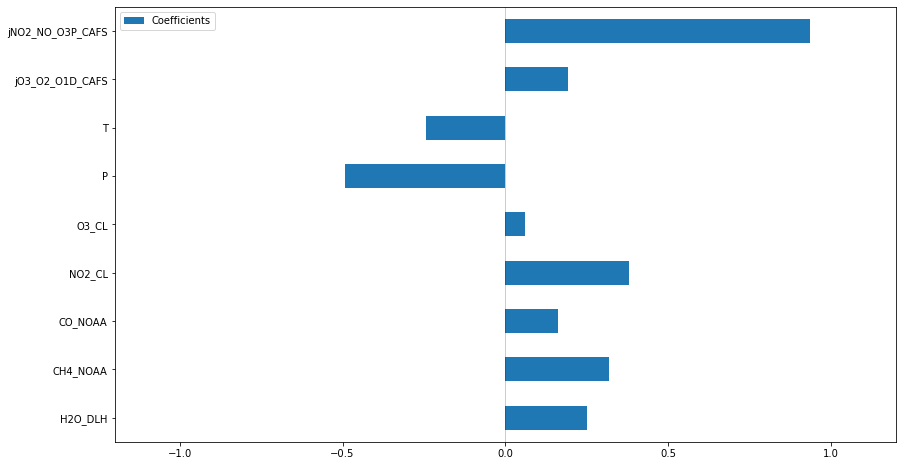

In [21]:
coefs.plot(kind='barh', figsize=(14, 8))
plt.xlim(-1.2, 1.2)
plt.axvline(x=0, color = 'k', alpha = 0.2, linewidth = 1)


# Check coefficients are legitimate with k fold cross validation

In [22]:
cv_results = cross_validate(rr, other_data, OH_data, cv=RepeatedKFold(n_splits=10, n_repeats=1),
    return_estimator=True, n_jobs=-1)

In [23]:
empty_list = []

In [24]:
for model in cv_results['estimator']:
    empty_list.append(model.coef_)

In [25]:
df_coefs = pd.DataFrame(empty_list) 

In [26]:
df_coefs.columns = [normalised_key_atom1_data.columns[1:10]]

In [27]:
df_coefs.transpose()

0         1         2         3         4         5  \
H2O_DLH           0.264173  0.260783  0.259543  0.267696  0.266439  0.262290   
CH4_NOAA          0.316903  0.313998  0.314880  0.315049  0.313004  0.318361   
CO_NOAA           0.154501  0.157564  0.162497  0.158847  0.159610  0.160250   
NO2_CL            0.399365  0.397858  0.391420  0.396415  0.391007  0.393747   
O3_CL             0.067236  0.063279  0.069128  0.072878  0.078919  0.078561   
P                -0.535028 -0.532155 -0.526439 -0.561097 -0.534588 -0.539607   
T                -0.206477 -0.206796 -0.211227 -0.180721 -0.204646 -0.195500   
jO3_O2_O1D_CAFS   0.182891  0.181085  0.183443  0.183228  0.187047  0.182165   
jNO2_NO_O3P_CAFS  0.925567  0.934233  0.931863  0.910529  0.920539  0.917188   

                         6         7         8         9  
H2O_DLH           0.260183  0.258971  0.257452  0.261214  
CH4_NOAA          0.316494  0.314682  0.318035  0.316066  
CO_NOAA           0.158608  0.159871  0.160723  0.161089  
NO2_CL            0.397555  0.393213  0.394798  0.393762  
O3_CL             0.062983  0.069859  0.072772  0.072425  
P                -0.526168 -0.509973 -0.526573 -0.532652  
T                -0.213129 -0.227747 -0.206890 -0.203914  
jO3_O2_O1D_CAFS   0.184909  0.186746  0.179870  0.182999  
jNO2_NO_O3P_CAFS  0.929403  0.936006  0.927931  0.926246

/home/shmh4/.conda/envs/netcdf/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Coefficient importance and its variability')

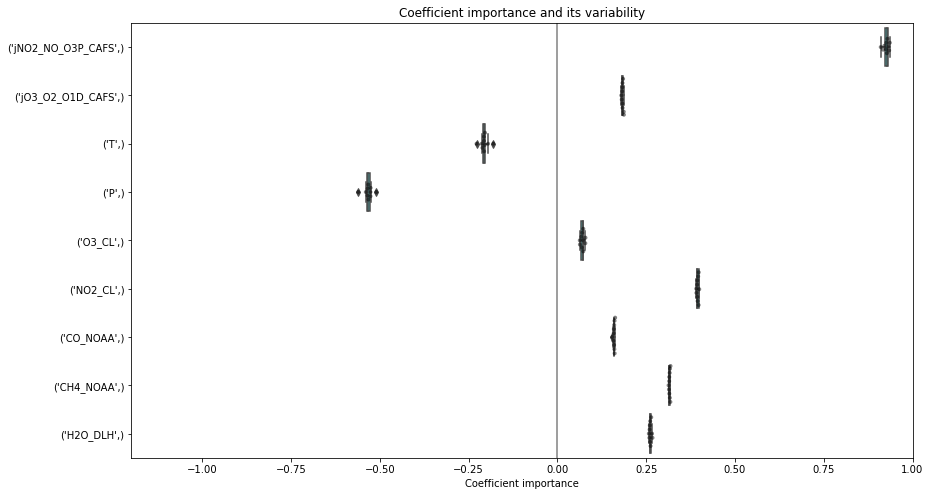

In [28]:
plt.figure(figsize=(14, 8))
sns.swarmplot(data=df_coefs, orient='h', color='k', alpha=0.5, size = 4)
sns.boxplot(data=df_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.gca().invert_yaxis()
plt.xlim(-1.2, 1,2)
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')


In [29]:
# ppm to concentration transformation function

In [30]:
def M(p, T):
    m = p*100 / (1.38065e-23 * T)
    return m/1000000

In [121]:
m_atmos = M(X_test['P'], X_test['T'])

In [142]:
X_test.index

Int64Index([213809, 219755, 219569, 212406, 213532, 194184, 202008, 205996,
            185759, 192812,
            ...
            206140, 210522, 201948, 210893, 220402, 206081, 206157, 202241,
            218929, 193585],
           dtype='int64', length=14567)

# Train quick neural net on ATom data

In [56]:
train_features = torch.tensor(X_train.values)
test_features = torch.tensor(X_test.values)
train_labels = torch.tensor(y_train.values).reshape(-1,1)
test_labels = torch.tensor(y_test.values).reshape(-1,1)

In [57]:
train_features, train_labels = Variable(train_features), Variable(train_labels)

In [58]:
class ModernAffineLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_probs=0.3):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_probs)

    def forward(self, x, final=False):
        x = self.linear(x)

        if not final:
            x = self.activation(x)
            x = self.dropout(x)

        x = self.bn(x)
        return x

In [79]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ModernAffineLayer(9, 256) # this is a block
        self.layer2 = ModernAffineLayer(256, 128)
        self.layer3 = ModernAffineLayer(128, 128)
        self.layer4 = ModernAffineLayer(128, 16)
        self.layer5 = ModernAffineLayer(16, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x, final=True)
        mean = x
        return mean

In [80]:
model = Model()

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay = 1e-13)
loss_func = torch.nn.MSELoss()

batch_size = 128
EPOCH = 25

In [82]:
torch_dataset = Data.TensorDataset(train_features, train_labels)

In [83]:
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size,
    shuffle=True, num_workers=2,)

In [84]:
def train_step(data, label):
    data = Variable(data).float()
    label = Variable(label).float()

    mean = model(data)
    loss = loss_func(mean, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.data

In [85]:
def train_epoch():
    for step, (data,label) in enumerate(loader):
        last_loss = train_step(data, label)
    return last_loss

In [86]:
for epoch in range(EPOCH):
    last_loss = train_epoch()
    print(f'Epoch: {epoch+1}, Loss: {last_loss}')

Epoch: 1, Loss: 2.0290873050689697
Epoch: 2, Loss: 2.087197780609131
Epoch: 3, Loss: 2.2983765602111816
Epoch: 4, Loss: 1.588435173034668
Epoch: 5, Loss: 1.8934975862503052
Epoch: 6, Loss: 2.200443983078003
Epoch: 7, Loss: 1.2521718740463257
Epoch: 8, Loss: 1.317257285118103
Epoch: 9, Loss: 1.3679882287979126
Epoch: 10, Loss: 0.9640268683433533
Epoch: 11, Loss: 0.795872151851654
Epoch: 12, Loss: 1.4961057901382446
Epoch: 13, Loss: 1.0495566129684448
Epoch: 14, Loss: 0.6299261450767517
Epoch: 15, Loss: 0.8885094523429871
Epoch: 16, Loss: 0.51937335729599
Epoch: 17, Loss: 0.5093220472335815
Epoch: 18, Loss: 0.7723338603973389
Epoch: 19, Loss: 0.5480281710624695
Epoch: 20, Loss: 0.4040556252002716
Epoch: 21, Loss: 0.44653791189193726
Epoch: 22, Loss: 0.43631550669670105
Epoch: 23, Loss: 0.525123655796051
Epoch: 24, Loss: 0.6213986873626709
Epoch: 25, Loss: 0.36575379967689514


In [87]:
net_applied_to_training_data = model(train_features.float()).detach().numpy()
net_applied_to_testing_data = model(test_features.float()).detach().numpy()

In [88]:
for _ in range(19):
    net_applied_to_testing_data_temp = model(test_features.float()).detach().numpy()
    net_applied_to_testing_data = np.concatenate((net_applied_to_testing_data, net_applied_to_testing_data_temp), axis=1)

In [89]:
mean_prediction = net_applied_to_testing_data.mean(axis=1)
var_prediction = net_applied_to_testing_data.var(axis=1)

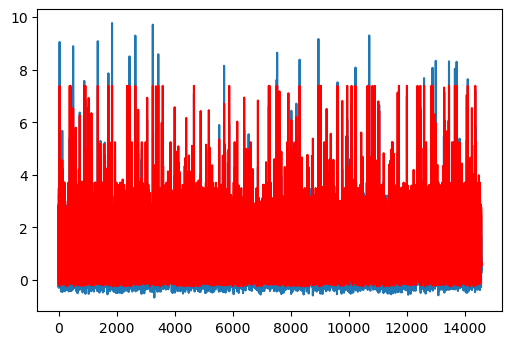

In [124]:
plt.figure(dpi=100)
plt.plot(mean_prediction)
#plt.fill_between(range(77676), all_net_outputs_mean - 25*all_net_outputs_var, all_net_outputs_mean + 25*all_net_outputs_var, alpha=0.2, color="b")
plt.plot(test_labels, color='r')
#plt.xlim(2000,2200)

(2000.0, 2600.0)

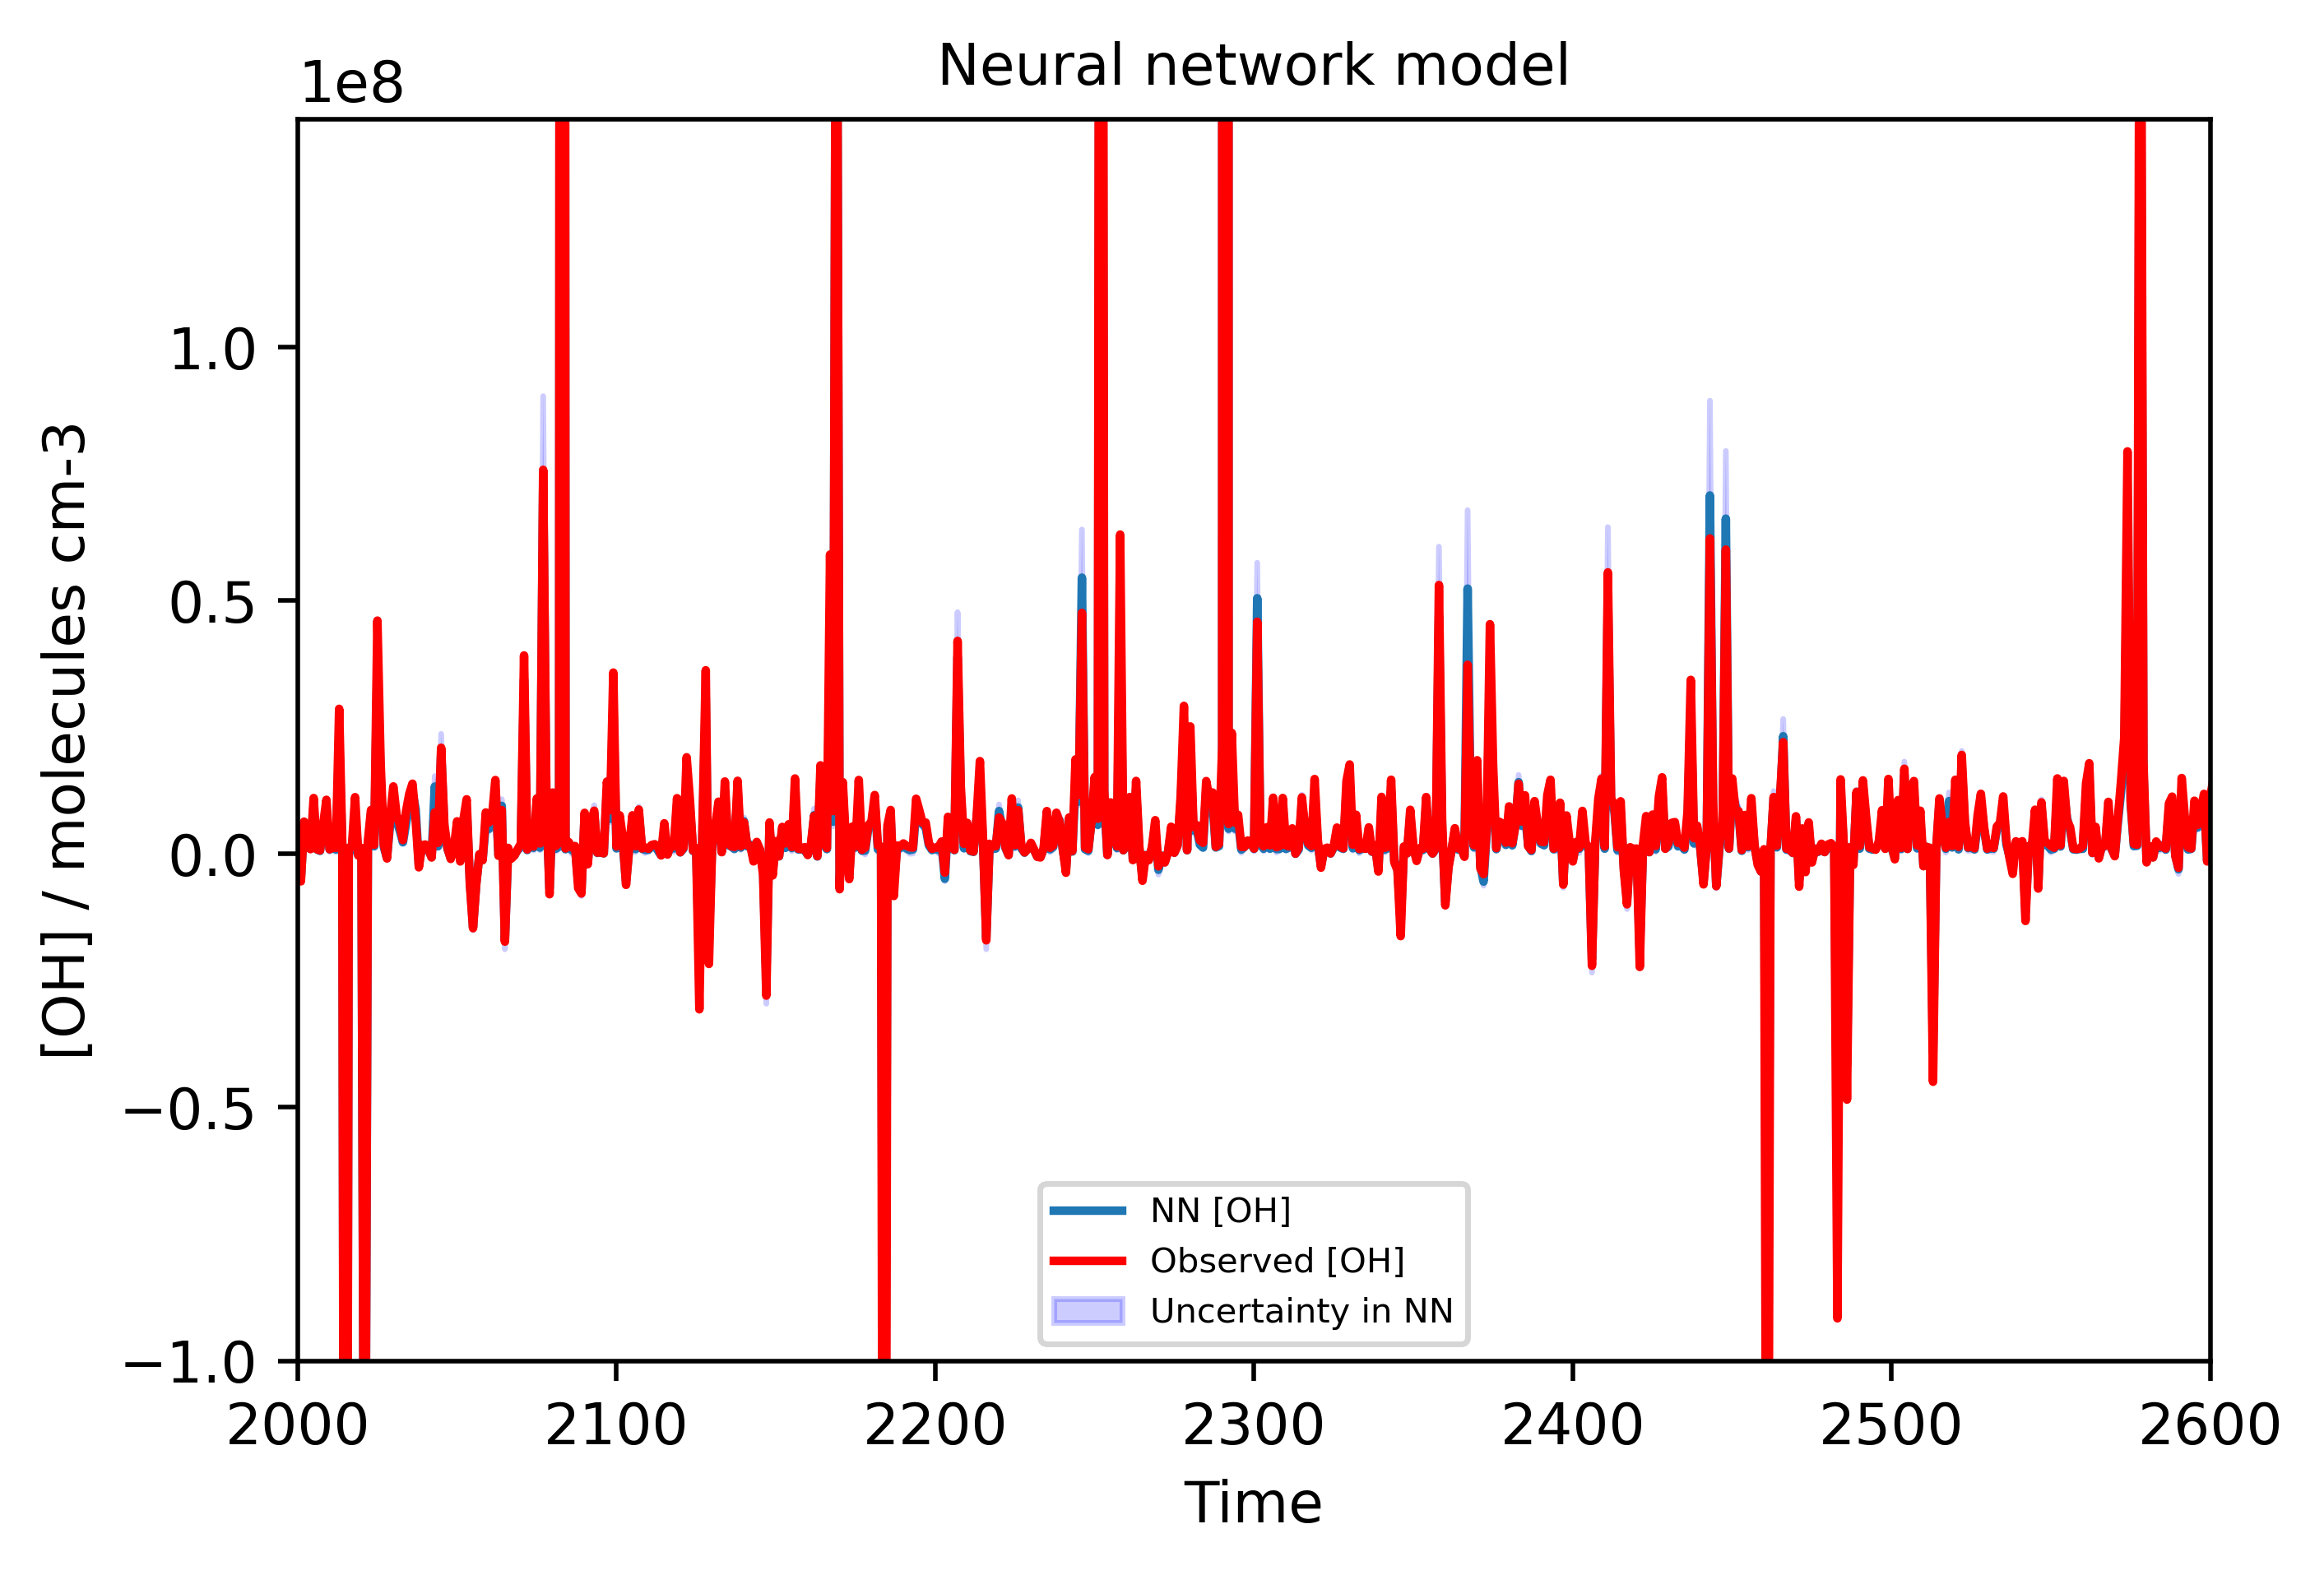

In [136]:
fig, ax1 = plt.subplots(dpi=500)

ax1.plot(range(14567), ((mean_prediction*OH_std) + OH_mean) * m_atmos * 1e-12, label = 'NN [OH]')
ax1.fill_between(range(14567), ((mean_prediction - np.sqrt(var_prediction))*OH_std + OH_mean)*m_atmos*1e-12, ((mean_prediction + np.sqrt(var_prediction))*OH_std + OH_mean)*m_atmos*1e-12, alpha=0.2, color="b", label='Uncertainty in NN')
ax1.plot(range(14567), ((y_test*OH_std) + OH_mean) * m_atmos * 1e-12, color='r', label='Observed [OH]')

#myFmt = mdates.DateFormatter('%H:%M')
#ax1.xaxis.set_major_formatter(myFmt)

ax1.set_ylabel('[OH] / molecules cm-3')
ax1.set_xlabel('Time')
ax1.legend(fontsize=6)
ax1.set_title('Neural network model', fontsize=10)
plt.ylim(-0.1e9, 1.45e8)
plt.xlim(2000,2600)

# Read in climate model data

In [175]:
specific_humidity_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/10/10.nc")
O3_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34001/34001.nc")
NO_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34002/34002.nc")
CH4_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34009/34009.nc")
CO_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34010/34010.nc")
HCHO_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34011/34011.nc")
OH_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34081/34081.nc")
HO2_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34082/34082.nc")
NO2_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/34996/34996.nc")
#NO_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/408/408.nc")
JO1D_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/50228/50228.nc")
JNO2_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/50229/50229.nc")
P_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/408/408.nc")
T_data = xr.open_dataset("/scratch/jmw240/ATom_Model_Data/ST_bv941/16004/16004.nc")

In [176]:
OH = OH_data.UM_m01s34i081_vn1105
OH_selected_time = OH.sel(time='2016-07-01T12:00:00.000000000')
OH_selected_time_height = OH_selected_time.isel(atmosphere_hybrid_height_coordinate=3) 
OH_selected_time_height_df = OH_selected_time_height.to_pandas()

In [177]:
OH_data

<xarray.Dataset>
Dimensions:                                   (atmosphere_hybrid_height_coordinate: 52, bnds: 2, latitude: 144, longitude: 192, time: 1488)
Coordinates:
  * time                                      (time) datetime64[ns] 2016-07-0...
  * longitude                                 (longitude) float64 0.9375 ... ...
  * latitude                                  (latitude) float64 -89.38 ... 8...
  * atmosphere_hybrid_height_coordinate       (atmosphere_hybrid_height_coordinate) float64 ...
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds                            (longitude, bnds) float64 ...
    latitude_bnds                             (latitude, bnds) float64 ...
    atmosphere_hybrid_height_coordinate_bnds  (atmosphere_hybrid_height_coordinate, bnds) float64 ...
    UM_m01s34i081_vn1105                      (time, atmosphere_hybrid_height_coordinate, latitude, longitude) float32 ...
Attributes:
    CDI:              Climate Data Interface version 1.9.5 (http://mpimet.mpg...
    history:          Thu Jul 23 21:56:38 2020: cdo mergetime 34081_10_19_Aug...
    source:           UM vn1105
    Conventions:      CF-1.6
    runid:            aaaaa
    stash_code:       34081
    lbtim:            11
    um_stash_source:  m01s34i081
    lbproc:           0
    submodel:         1
    CDO:              Climate Data Operators version 1.9.5 (http://mpimet.mpg...

In [277]:
def data(stash,suite,start,finish, t, h):
    base = "/scratch/jmw240/ATom_Model_Data/"
    input_data=xr.open_dataset(base+suite+'/'+stash+'/'+stash+'.nc')
    temp_var=[a for a in input_data.variables][-1]
    x = input_data[temp_var][start:finish,h,:,:]
    x_selected_time_height = x[t]
    #x_selected_time_height = x_selected_time.isel(atmosphere_hybrid_height_coordinate=h) 
    x_selected_time_height_df = x_selected_time_height.to_pandas()
    #output_data=input_data.variables[temp_var][start:finish,:,:,:]
    x_selected_time_height_array = x_selected_time_height_df.to_numpy()

    return x_selected_time_height_array

In [278]:
spec_hum_dict = {}
for _ in range(0,22):
    spec_hum_dict[_] = data('10', 'ST_bv941', 12, 13, 0, _)

In [279]:
O3_dict = {}
for _ in range(0,22):
    O3_dict[_] = data('34001', 'ST_bv941', 12, 13, 0, _)

In [280]:
NO_dict = {}
for _ in range(0,22):
    NO_dict[_] = data('34002', 'ST_bv941', 12, 13, 0, _)

In [281]:
CH4_dict = {}
for _ in range(0,22):
    CH4_dict[_] = data('34009', 'ST_bv941', 12, 13, 0, _)

In [282]:
CO_dict = {}
for _ in range(0,22):
    CO_dict[_] = data('34010', 'ST_bv941', 12, 13, 0, _)

In [283]:
HCHO_dict = {}
for _ in range(0,22):
    HCHO_dict[_] = data('34011', 'ST_bv941', 12, 13, 0, _)

In [284]:
OH_dict = {}
for _ in range(0,22):
    OH_dict[_] = data('34081', 'ST_bv941', 12, 13, 0, _)

In [285]:
HO2_dict = {}
for _ in range(0,22):
    HO2_dict[_] = data('34082', 'ST_bv941', 12, 13, 0, _)

In [286]:
NO2_dict = {}
for _ in range(0,22):
    NO2_dict[_] = data('34996', 'ST_bv941', 12, 13, 0, _)

In [287]:
JO1D_dict = {}
for _ in range(0,22):
    JO1D_dict[_] = data('50228', 'ST_bv941', 12, 13, 0, _)

In [288]:
JNO2_dict = {}
for _ in range(0,22):
    JNO2_dict[_] = data('50229', 'ST_bv941', 12, 13, 0, _)

In [289]:
P_dict = {}
for _ in range(0,22):
    P_dict[_] = data('408', 'ST_bv941', 12, 13, 0, _)

In [290]:
T_dict = {}
for _ in range(0,22):
    T_dict[_] = data('16004', 'ST_bv941', 12, 13, 0, _)

In [291]:
stacks = {}
for i in range(0,22):
    stacks[i] = np.dstack((spec_hum_dict[i],CH4_dict[i],CO_dict[i],NO2_dict[i],O3_dict[i],P_dict[i],T_dict[i],JO1D_dict[i],JNO2_dict[i]))

In [292]:
stacks[0].shape

(144, 192, 9)

In [293]:
stacks_columns_means = {}
stacks_columns_stds = {}
stacks_means = {}
stacks_stds = {}
for _ in range(22):
    stacks_columns_means[_] = stacks[_].mean(axis = 1)
    stacks_columns_stds[_] = stacks[_].std(axis=1)
    stacks_means[_] = stacks_columns_means[_].mean(axis = 0)
    stacks_stds[_] = stacks_columns_stds[_].mean(axis = 0)

In [294]:
stacks_means[0].shape

(9,)

In [295]:
stacks_means[4]

array([7.4247993e-03, 1.0204205e-06, 6.7746427e-08, 1.9035633e-10,
       5.4786035e-08, 9.4051617e+04, 2.8078552e+02, 6.0256466e-06,
       2.9840739e-03], dtype=float32)

In [296]:
stacked_means = np.vstack((stacks_means[0], stacks_means[1], stacks_means[2], stacks_means[3], stacks_means[4], stacks_means[5], 
                           stacks_means[6], stacks_means[7], stacks_means[8], stacks_means[9], stacks_means[10], stacks_means[11], 
                           stacks_means[12], stacks_means[13], stacks_means[14], stacks_means[15], stacks_means[16], stacks_means[17], stacks_means[18],
                           stacks_means[19], stacks_means[20], stacks_means[21]))
stacked_stds = np.vstack((stacks_stds[0], stacks_stds[1], stacks_stds[2], stacks_stds[3], stacks_stds[4], stacks_stds[5], 
                          stacks_stds[6], stacks_stds[7], stacks_stds[8], stacks_stds[9], stacks_stds[10], stacks_stds[11], 
                          stacks_stds[12], stacks_stds[13], stacks_stds[14], stacks_stds[15], stacks_stds[16], stacks_stds[17], 
                          stacks_stds[18], stacks_stds[19], stacks_stds[20], stacks_stds[21]))

In [297]:
OH_dict[0].shape

(144, 192)

In [298]:
OH_column_mean = {}
OH_column_std = {}
OH_means = {}
OH_stds = {}
for _ in range(22):
    OH_column_mean[_] = OH_dict[_].mean(axis = 1)
    OH_column_std[_] = OH_dict[_].std(axis=1)
    OH_means[_] = OH_column_mean[_].mean(axis = 0)
    OH_stds[_] = OH_column_std[_].mean(axis = 0)

In [299]:
OH_stacked_means = np.vstack((OH_means[0], OH_means[1], OH_means[2], OH_means[3], OH_means[4], OH_means[5], 
                             OH_means[6], OH_means[7], OH_means[8], OH_means[9], OH_means[10], OH_means[11], 
                             OH_means[12], OH_means[13], OH_means[14], OH_means[15], OH_means[16], OH_means[17], 
                             OH_means[18], OH_means[19], OH_means[20], OH_means[21]))
OH_stacked_stds = np.vstack((OH_stds[0], OH_stds[1], OH_stds[2], OH_stds[3], OH_stds[4], OH_stds[5], 
                             OH_stds[6], OH_stds[7], OH_stds[8], OH_stds[9], OH_stds[10], OH_stds[11], 
                             OH_stds[12], OH_stds[13], OH_stds[14], OH_stds[15], OH_stds[16], OH_stds[17], 
                             OH_stds[18], OH_stds[19], OH_stds[20], OH_stds[21]))

In [300]:
OH_means_over_height = OH_stacked_means.mean(axis=0)
OH_stds_over_height = OH_stacked_stds.mean(axis=0)

In [301]:
norm_OH = {}
for _ in range(22):
    norm_OH[_] = (OH_dict[_] - OH_means_over_height)/OH_stds_over_height

In [302]:
means_over_height = stacked_means.mean(axis=0)
stds_over_height = stacked_stds.mean(axis=0)

In [303]:
norm_stacks = {}
for _ in range(22):
    norm_stacks[_] = (stacks[_] - means_over_height)/stds_over_height

In [304]:
norm_stacks[0].shape

(144, 192, 9)

In [305]:
preds = rr.predict(norm_stacks[0][0,:,:])

In [306]:
preds.shape

(192,)

In [307]:
#preds_dict = {}
def predict(h):
    preds = rr.predict(norm_stacks[h][0,:,:])
    for _ in range(1,144):
        preds_new = rr.predict(norm_stacks[h][_,:,:])
        preds = np.vstack((preds, preds_new))
    return preds

In [308]:
predictions = {}
for _ in range(22):
    predictions[_] = predict(_)

In [309]:
mixing_ratio_predictions = {}
for _ in range(22):
    mixing_ratio_predictions[_] = (predictions[_]*OH_stds_over_height) + OH_means_over_height 

In [310]:
mixing_ratio_preds_dict = {}
for _ in range(22):
    mixing_ratio_preds_dict[_] = xr.DataArray(mixing_ratio_predictions[_], coords=[np.linspace(-89.375, 89.375, 144),np.linspace(0.9375, 359.0625, 192)],
       dims=("latitude", "longitude"))

Text(0.5, 1.0, 'OH at height 0')

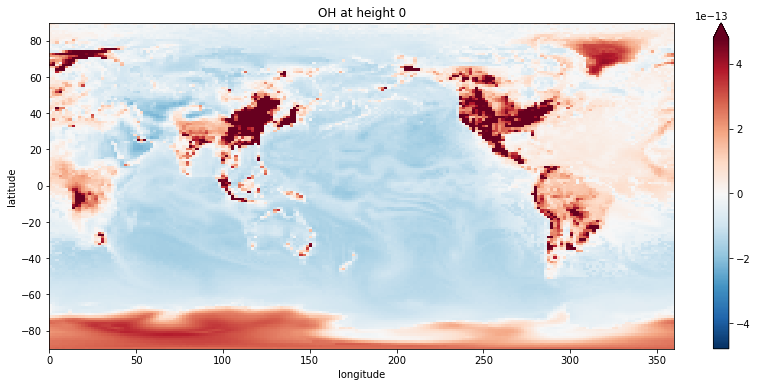

In [212]:
mixing_ratio_preds_dict[0].plot.pcolormesh(figsize=(14,6), robust=True)
plt.title('OH at height 0')

In [213]:
m_atmos_dict = {}
for _ in range(22):
    m_atmos_dict[_] = M(P_dict[_], T_dict[_])

In [214]:
conc_preds_dict = {}
for _ in range(22):
    conc_preds_dict[_] = (mixing_ratio_preds_dict[_] * m_atmos_dict[_])

In [215]:
conc_preds_dict[0]

<xarray.DataArray (latitude: 144, longitude: 192)>
array([[ 6.25624142e+08,  6.24078078e+08,  6.26848702e+08, ...,
         6.23708302e+08,  6.23438991e+08,  6.24254962e+08],
       [ 6.20699793e+08,  6.22869111e+08,  6.24868811e+08, ...,
         6.13931033e+08,  6.16458807e+08,  6.18322909e+08],
       [ 6.07226789e+08,  6.09489637e+08,  6.11779850e+08, ...,
         5.98875965e+08,  6.01920327e+08,  6.04762440e+08],
       ...,
       [ 2.48236123e+07, -2.88637936e+07, -1.85529615e+07, ...,
         5.07637723e+07,  1.09692148e+08,  2.72272398e+07],
       [ 7.74397576e+07,  2.83530907e+07,  6.62698612e+07, ...,
         1.10961474e+07,  5.62208493e+07,  4.57993257e+07],
       [ 1.71994247e+08,  1.31806792e+08,  6.88346275e+07, ...,
         3.33047488e+07,  7.54348921e+07,  1.25945347e+08]])
Coordinates:
  * latitude   (latitude) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1

Text(0.5, 1.0, 'OH at height 0')

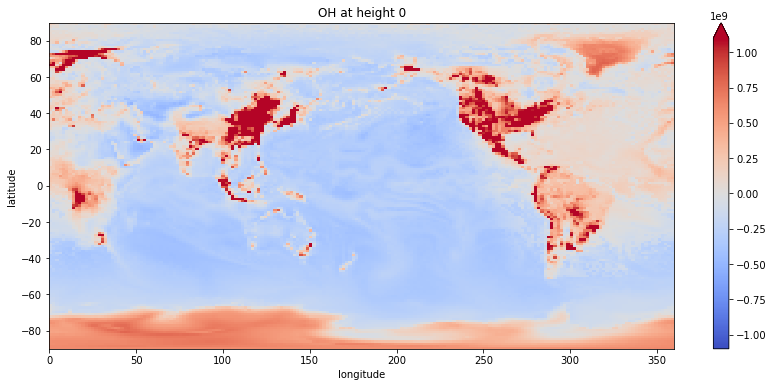

In [326]:
conc_preds_dict[0].plot.pcolormesh(figsize=(14,6), robust=True, cmap = 'coolwarm')
#fig.colorbar(conc_preds_dict[0])
#plt.colorbar(x, label='mo')
plt.title('OH at height 0')

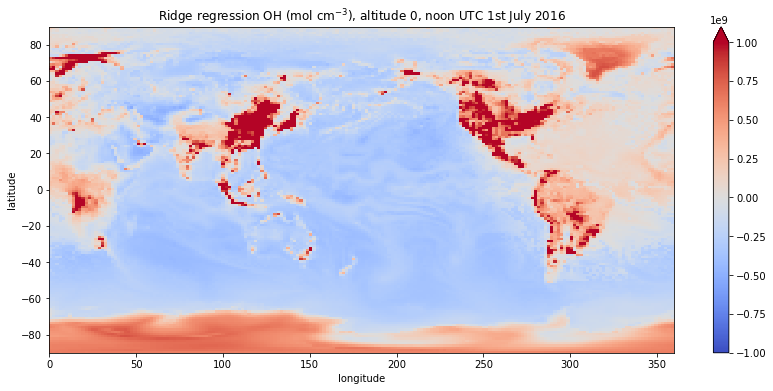

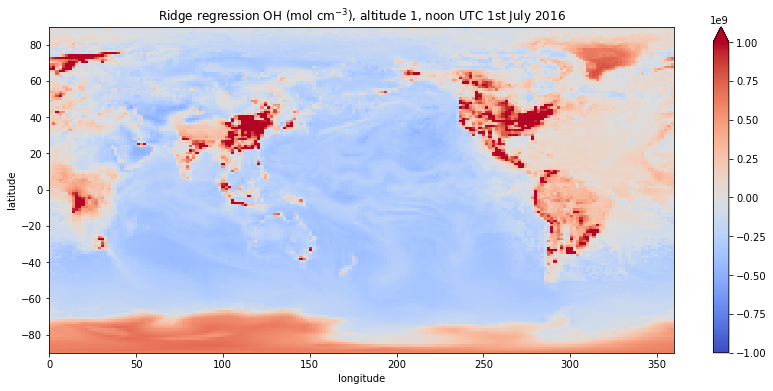

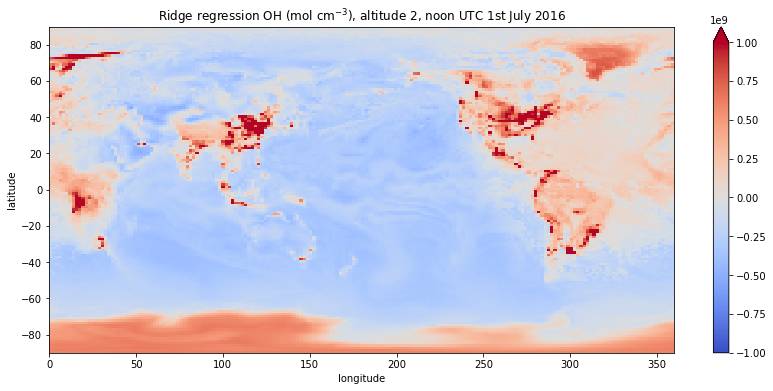

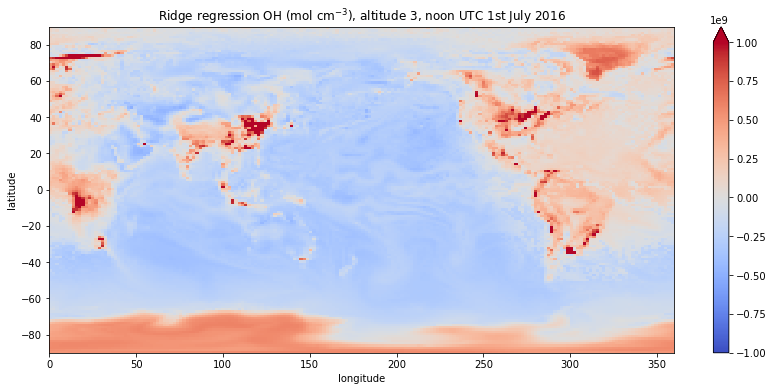

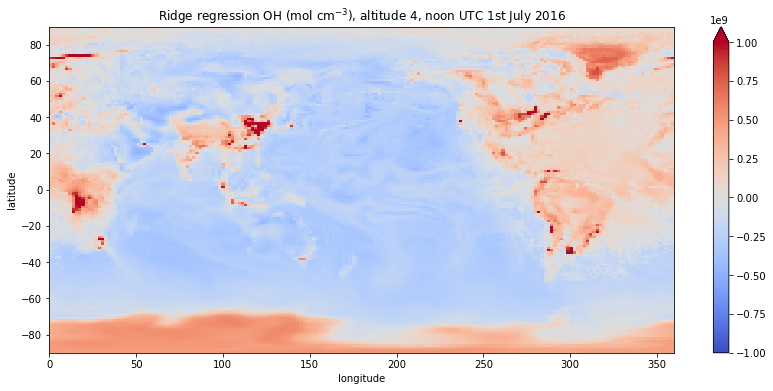

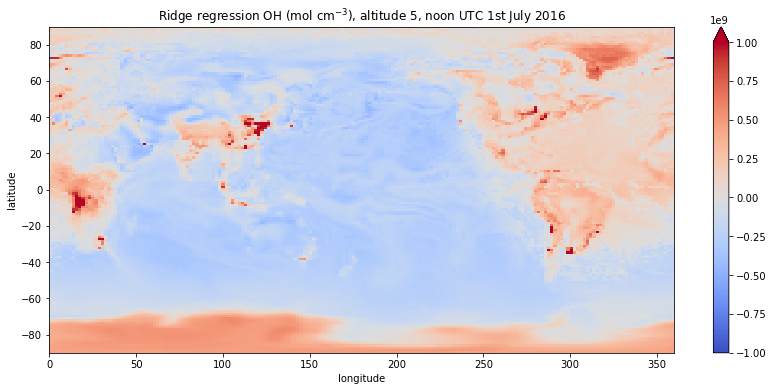

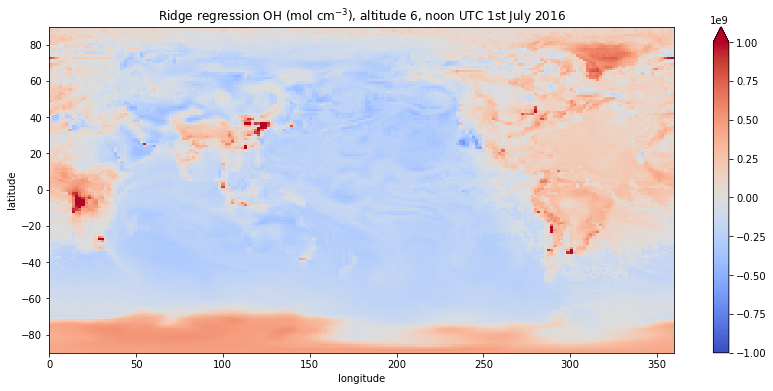

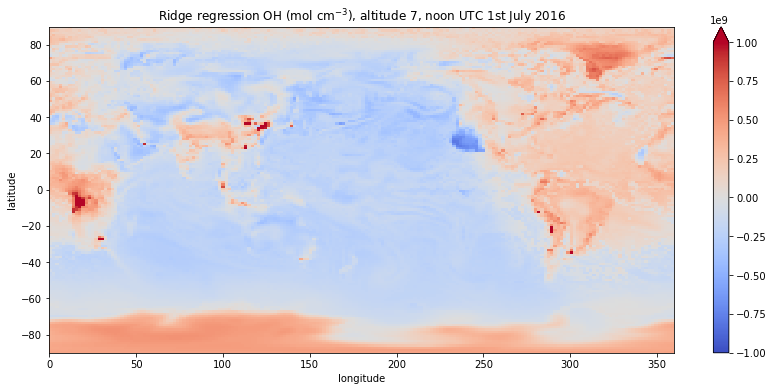

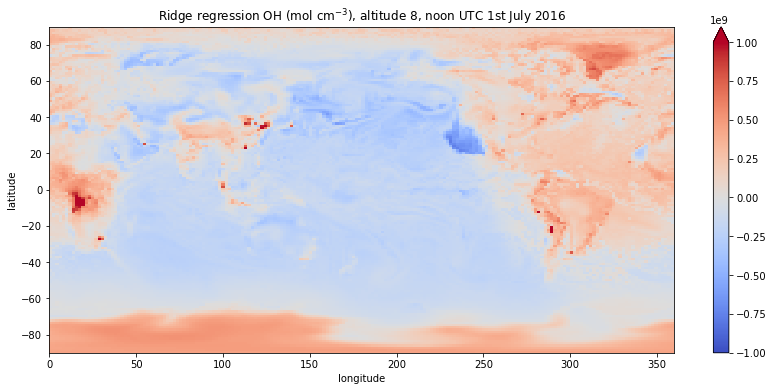

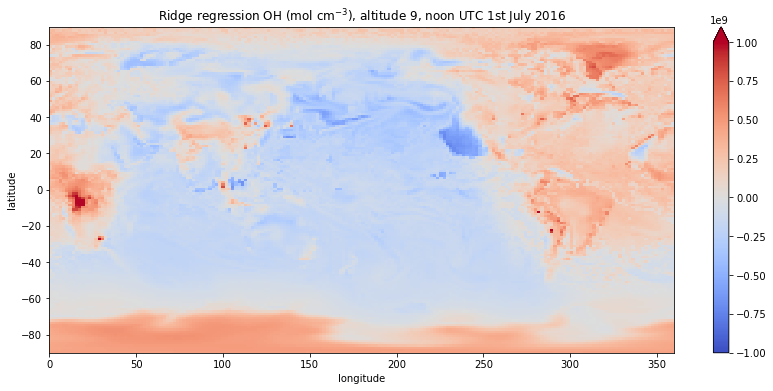

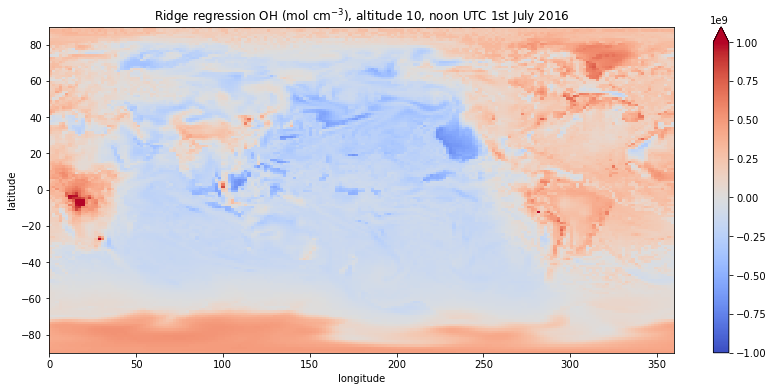

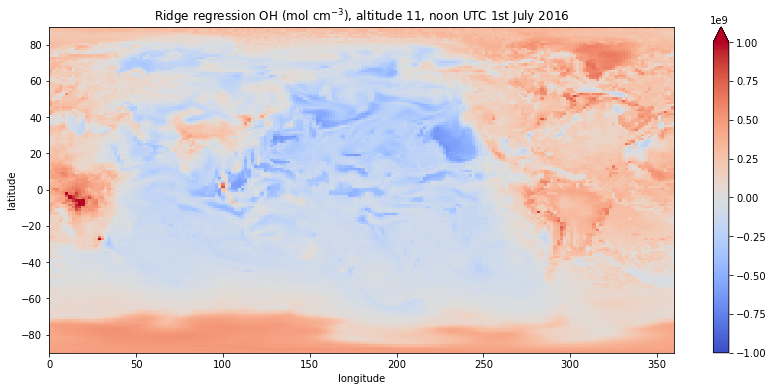

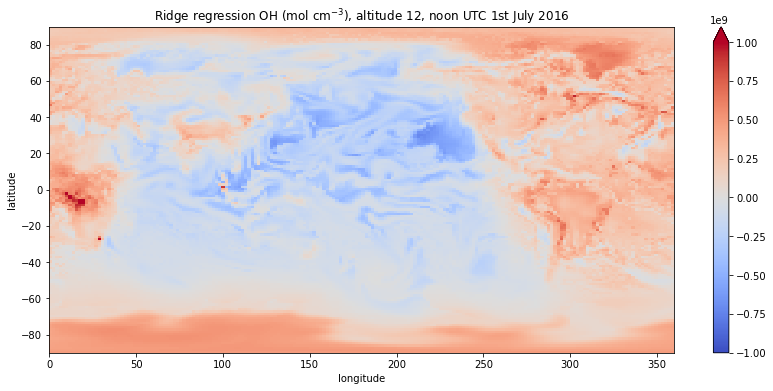

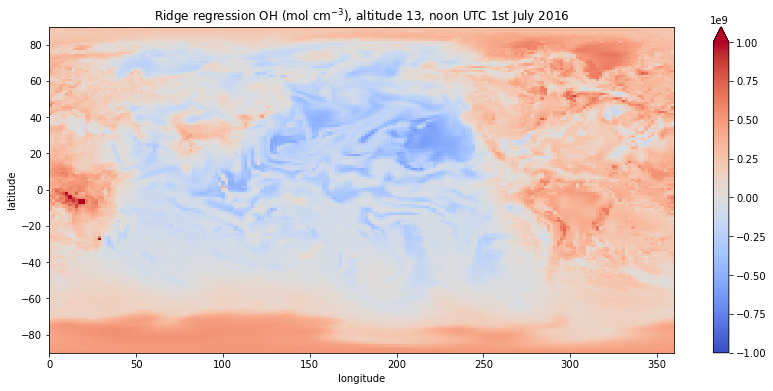

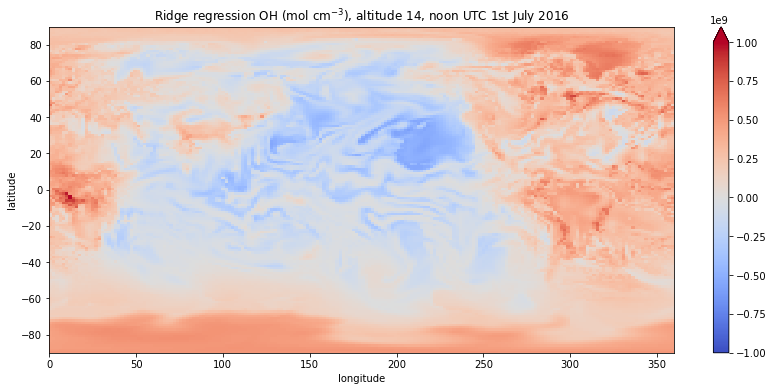

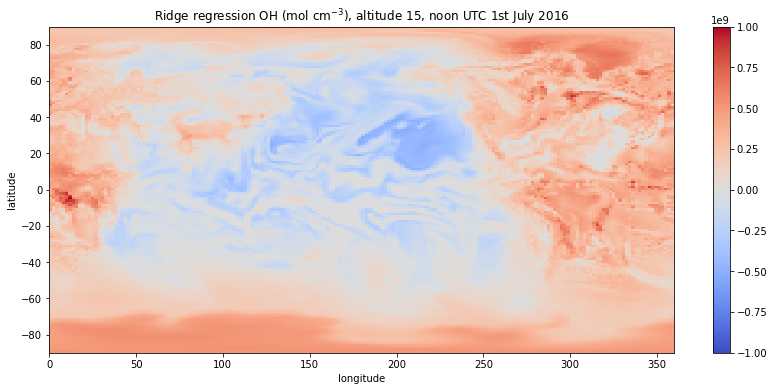

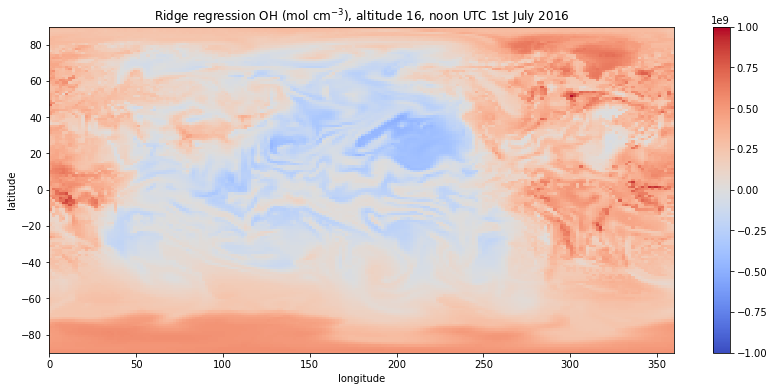

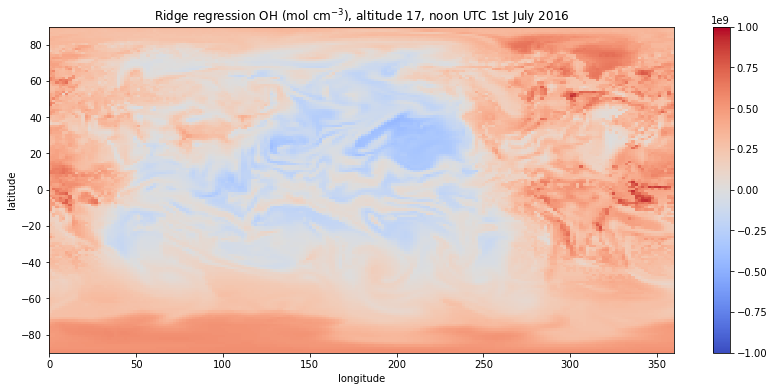

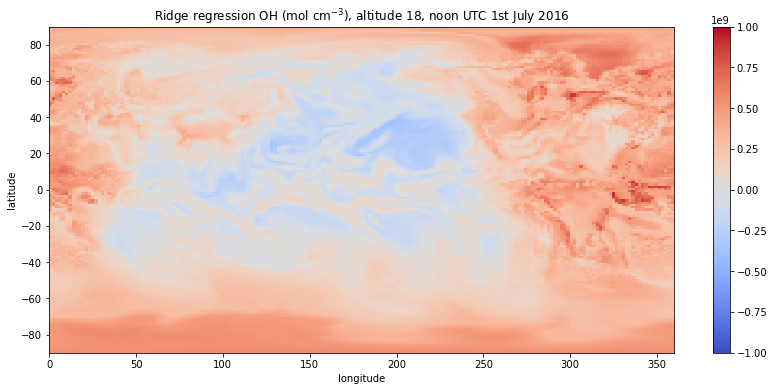

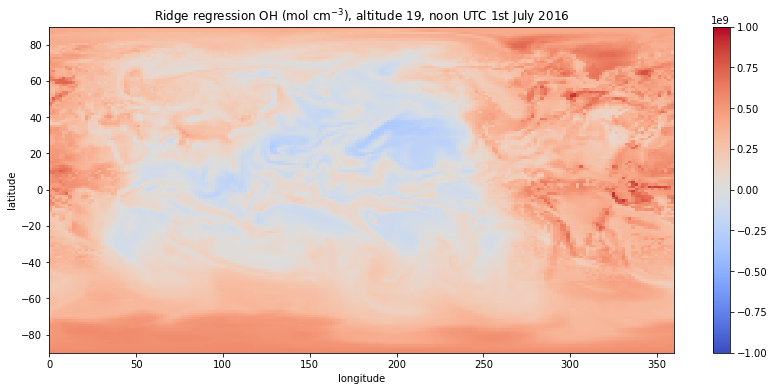

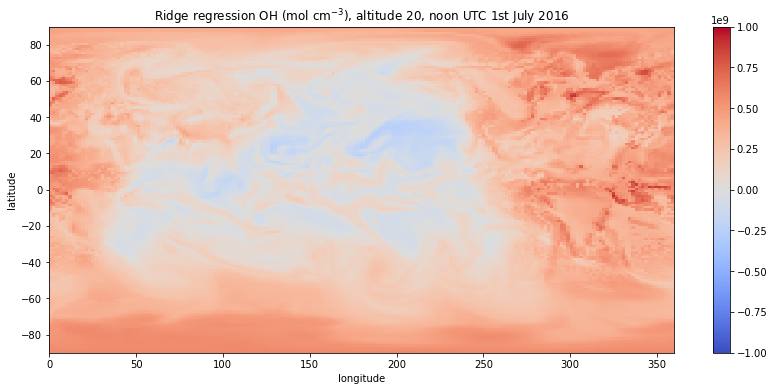

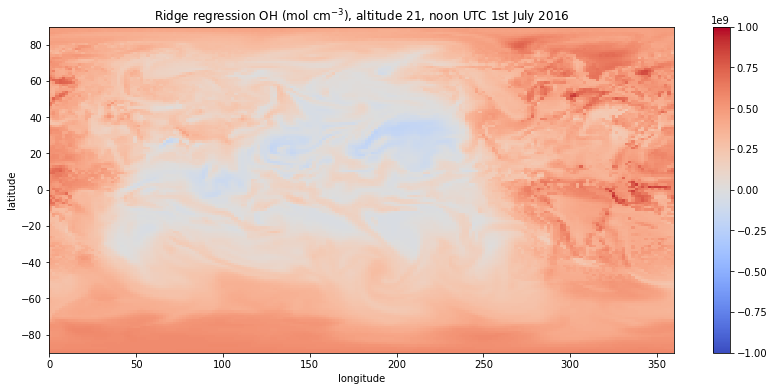

In [330]:
for _ in range(22):
    conc_preds_dict[_].plot.pcolormesh(figsize=(14,6), robust=True, vmin=-1e9, vmax=1e9, cmap='coolwarm')
    plt.title('Ridge regression OH (mol cm$^{-3}$), altitude '+str(_)+', noon UTC 1st July 2016')

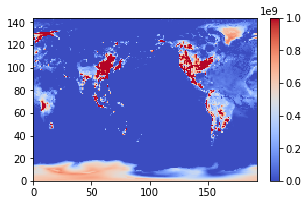

KeyError: 22

In [332]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5, 3))

cax = ax.pcolormesh(conc_preds_dict[0], cmap = 'coolwarm', vmin=1e-9, vmax=1e9)

#cax = ax.pcolormesh(x, y, G[:-1, :-1, 0],
#vmin=-1, vmax=1, cmap='Blues')

fig.colorbar(cax)
 
def animate(i):
     cax.set_array(conc_preds_dict[i])
        
anim = FuncAnimation(fig, animate, interval=100)
 
plt.draw()
plt.show()

anim.save('film2.mp4')

In [218]:
conc_OH_dict = {}
for _ in range(22):
    conc_OH_dict[_] = (OH_dict[_] * m_atmos_dict[_])

In [336]:
for _ in range(22):
    conc_OH_dict[_] = xr.DataArray(conc_OH_dict[_], coords=[np.linspace(-89.375, 89.375, 144),np.linspace(0.9375, 359.0625, 192)],
       dims=("latitude", "longitude"))

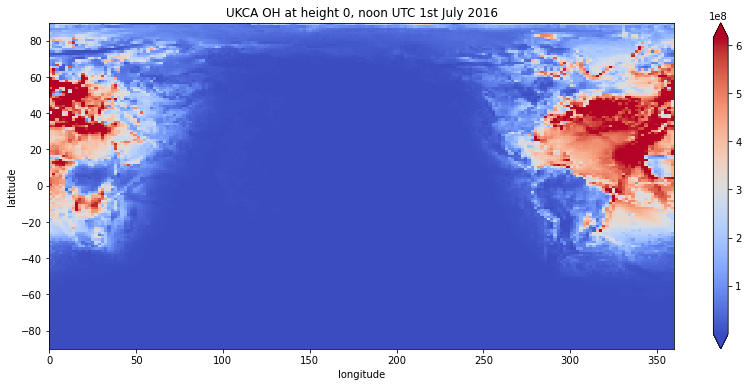

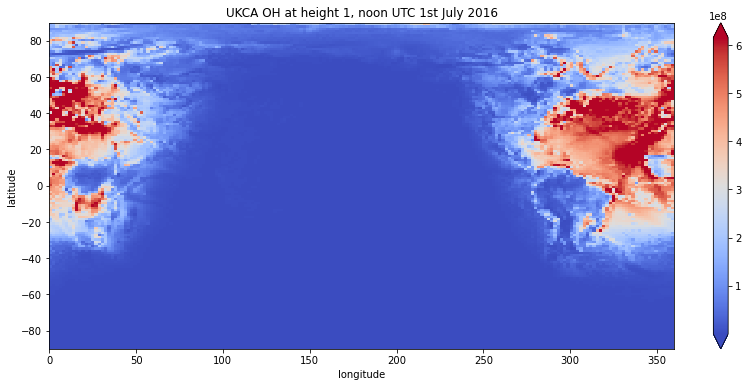

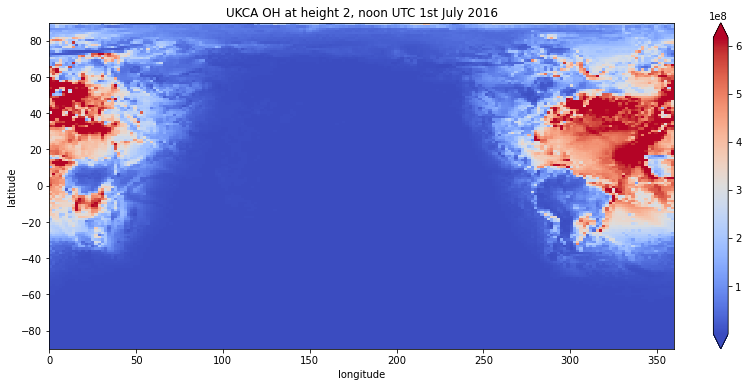

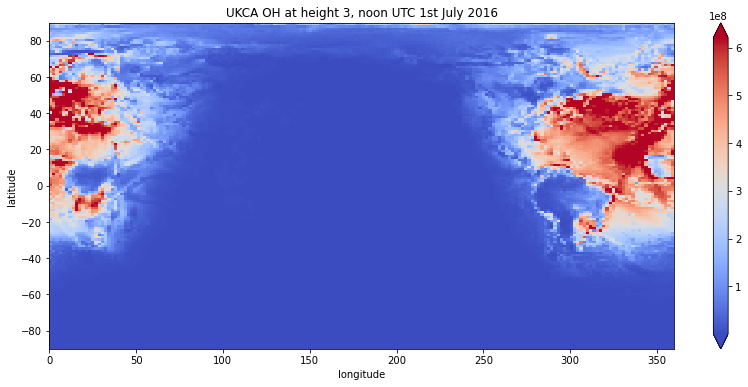

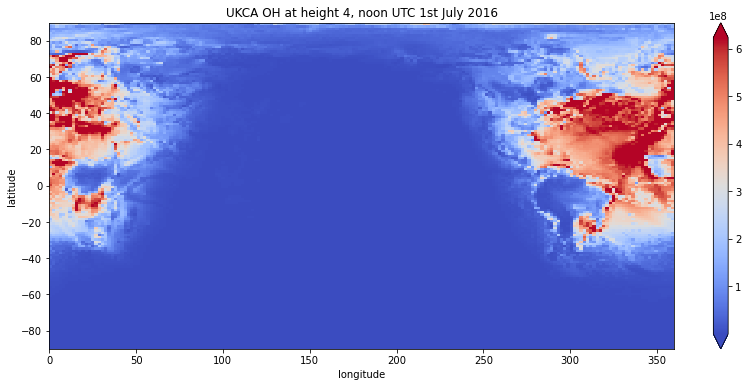

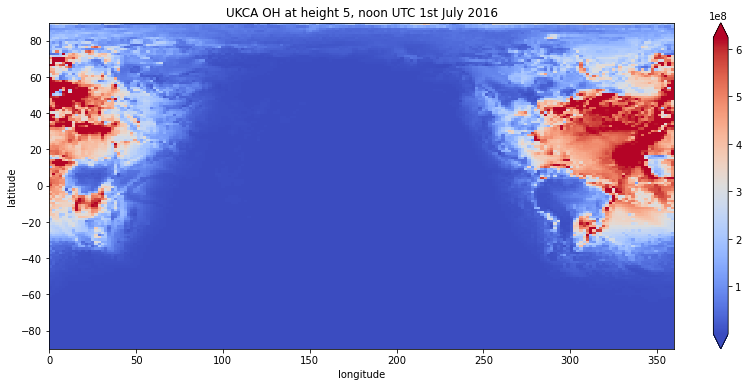

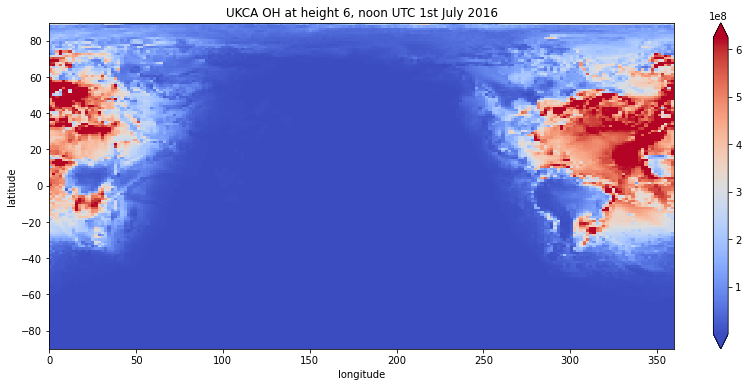

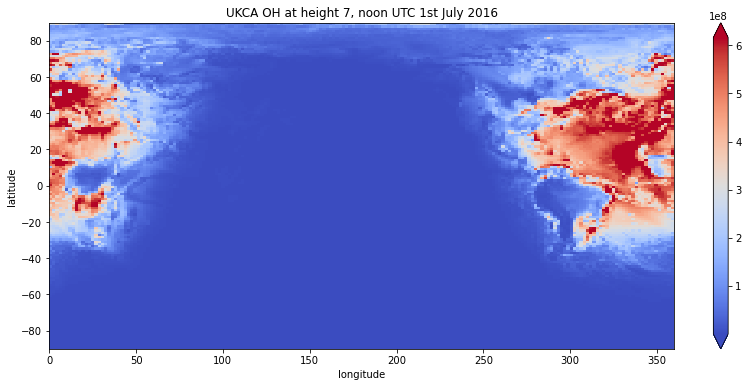

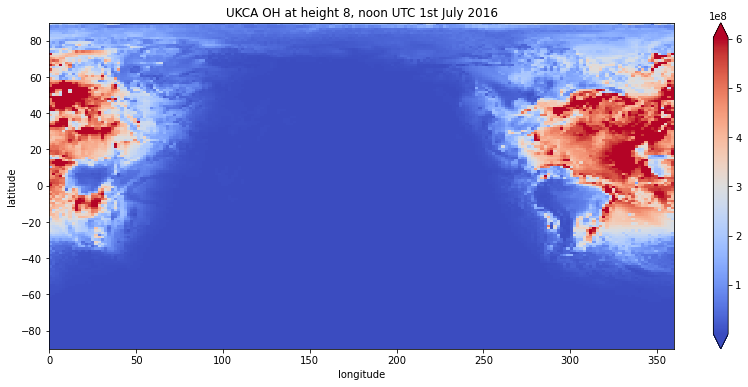

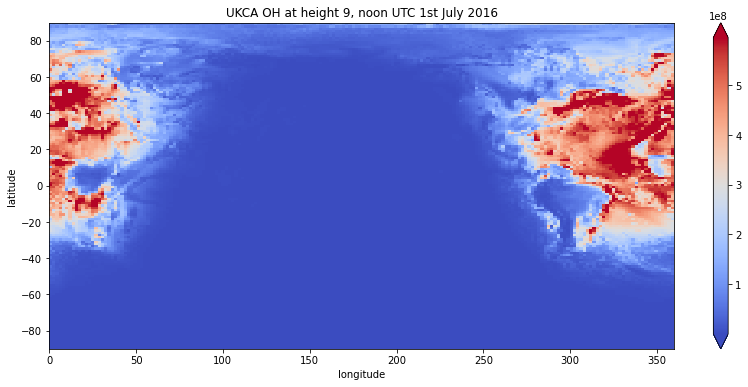

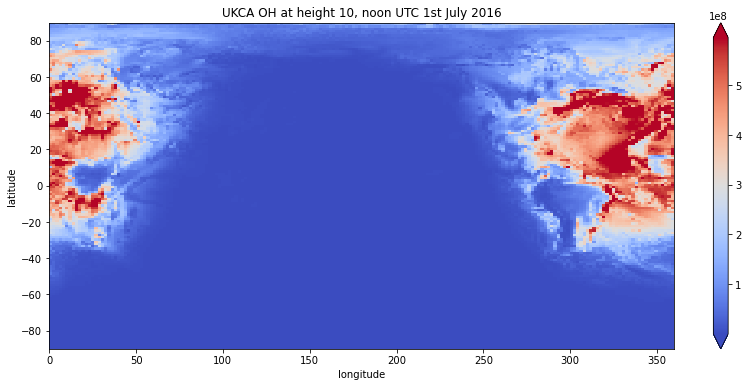

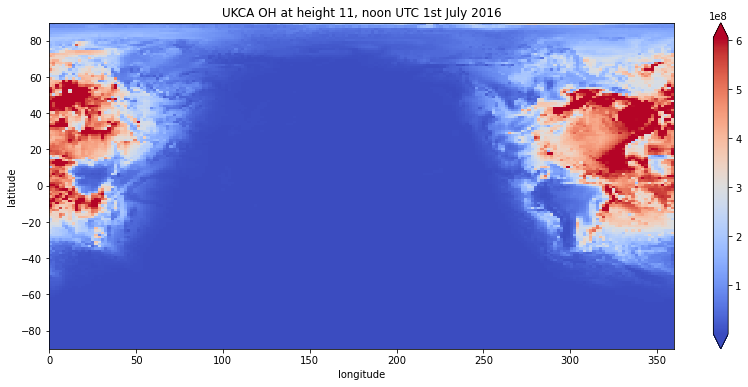

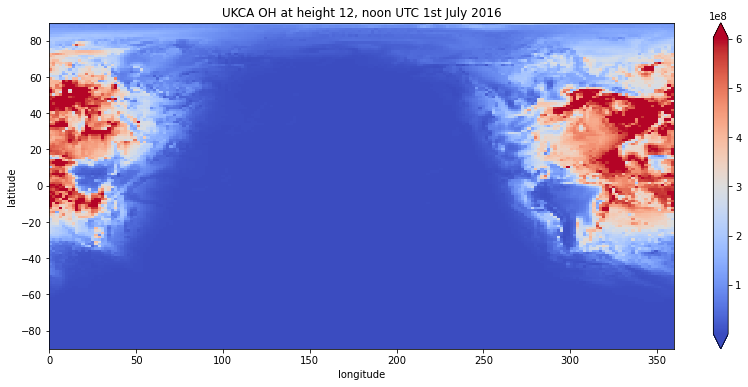

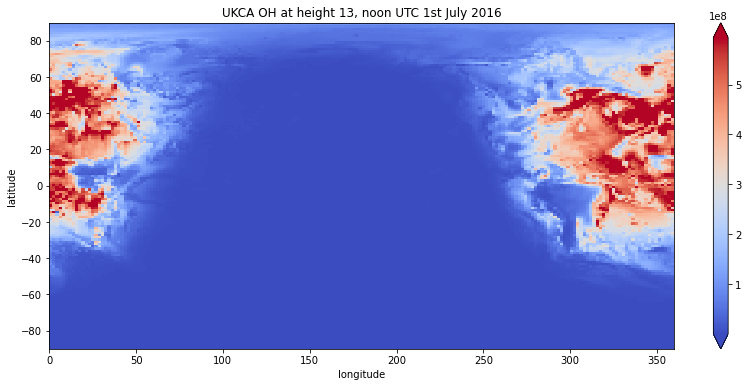

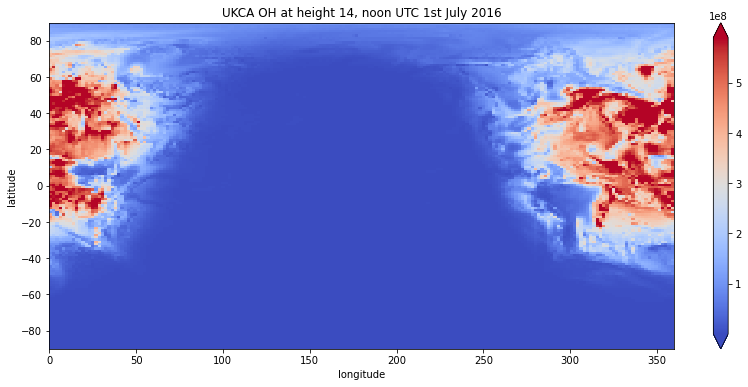

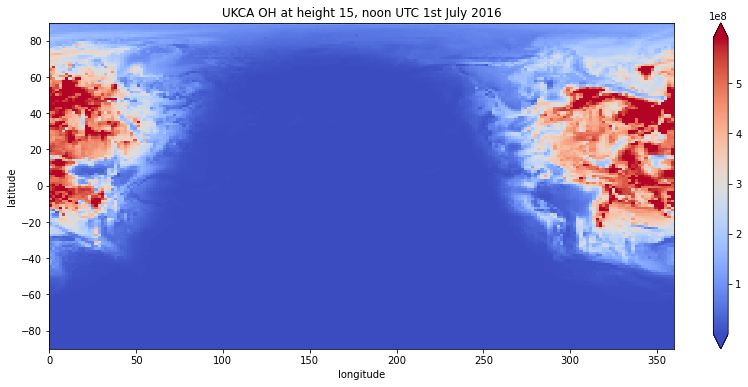

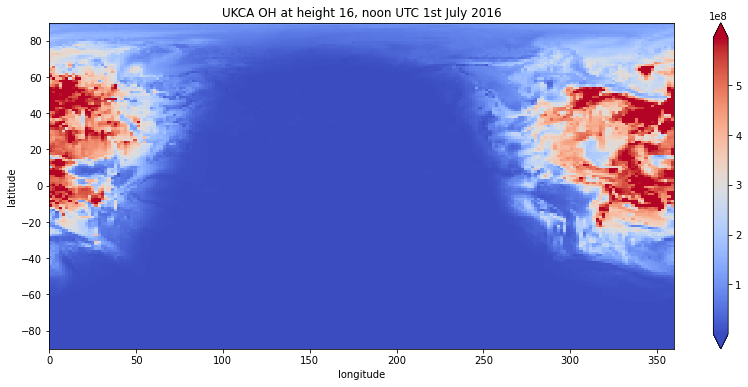

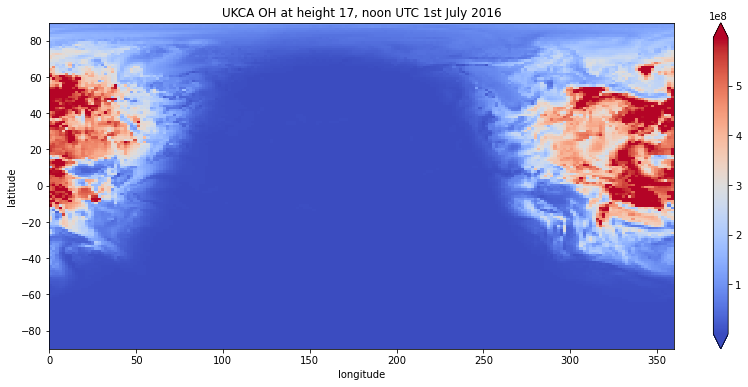

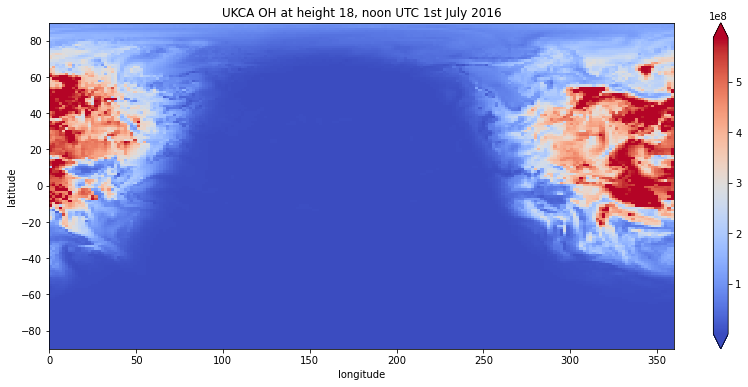

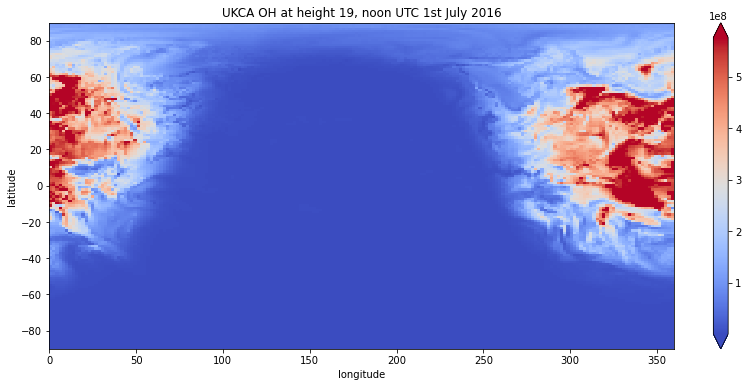

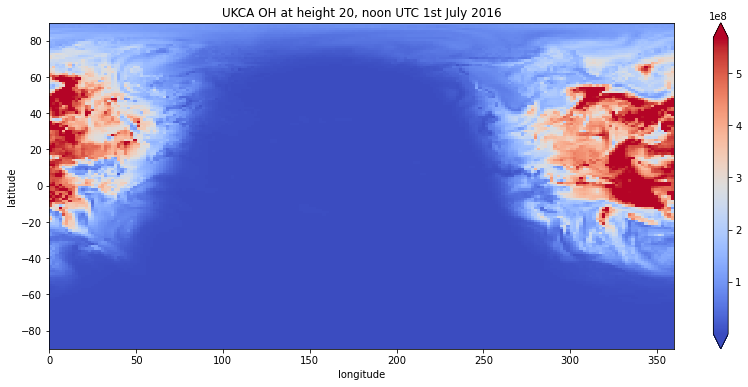

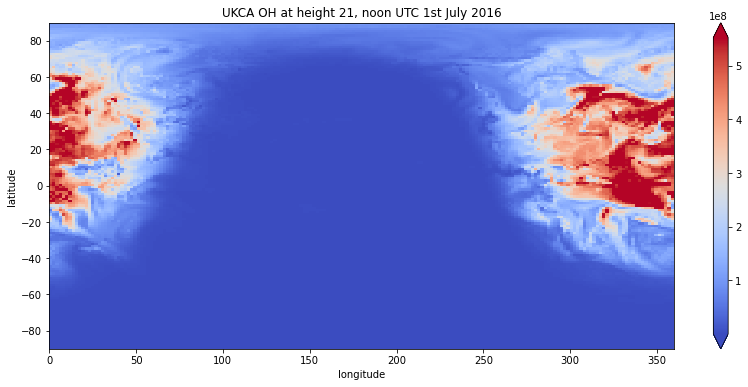

In [346]:
### OH from UKCA
for _ in range(22):
    conc_OH_dict[_].plot.pcolormesh(figsize=(14,6), robust=True, cmap='coolwarm')
    plt.title('UKCA OH at height ' +str(_)+ ', noon UTC 1st July 2016')

In [258]:
OH_comparison_dict = {}
for _ in range(22):
    OH_comparison_dict[_] = xr.DataArray((conc_preds_dict[_]-conc_OH_dict[_]), coords=[np.linspace(-89.375, 89.375, 144),np.linspace(0.9375, 359.0625, 192)],
       dims=("latitude", "longitude"))

Text(0.5, 1.0, 'OH at height 9, noon UTC 1st July 2016')

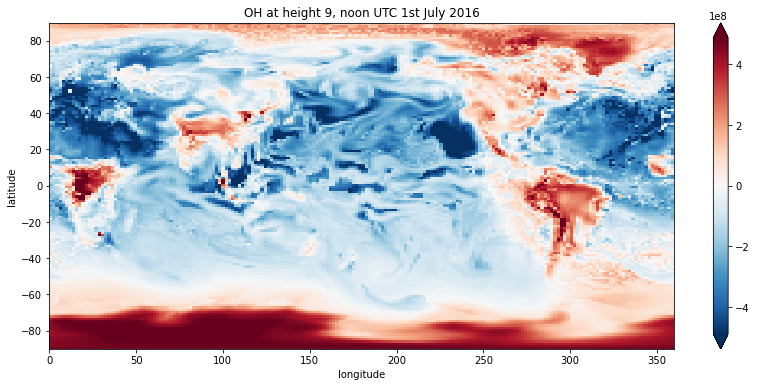

In [260]:
### OH predicted by ridge regression - UKCA OH, RR trained on ATom data
OH_comparison_dict[11].plot.pcolormesh(figsize=(14,6), robust=True)
plt.title('OH at height 9, noon UTC 1st July 2016')

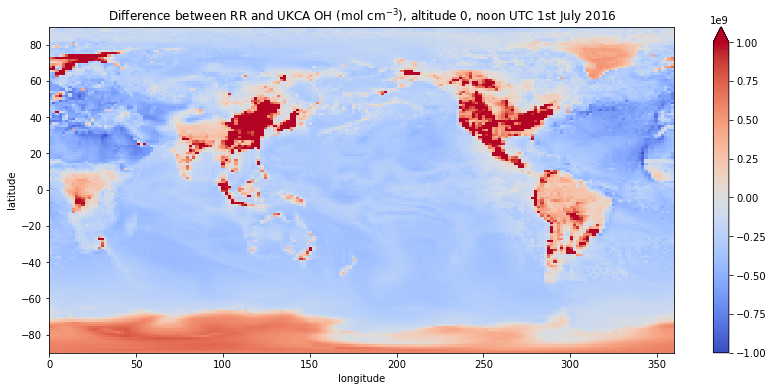

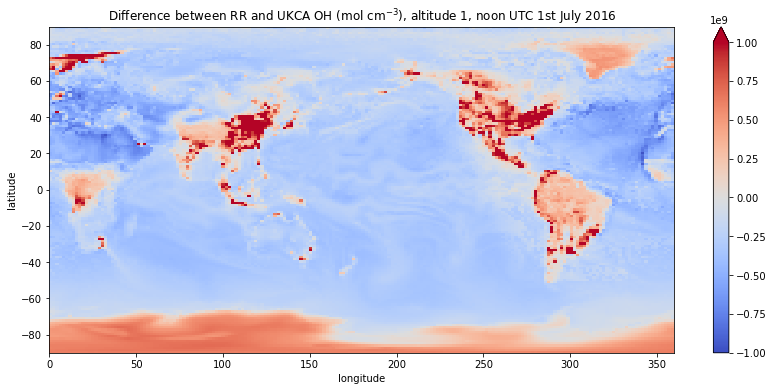

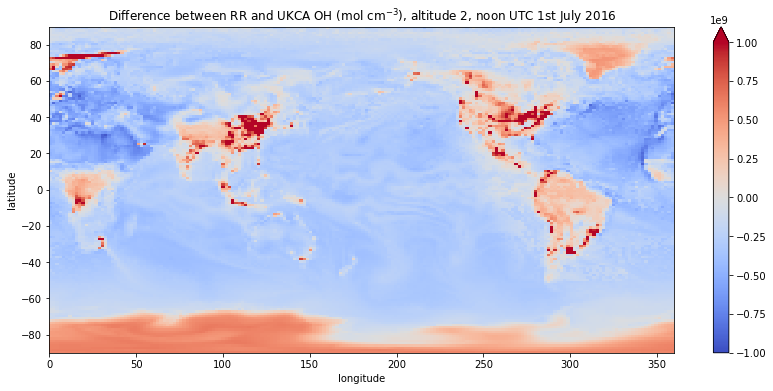

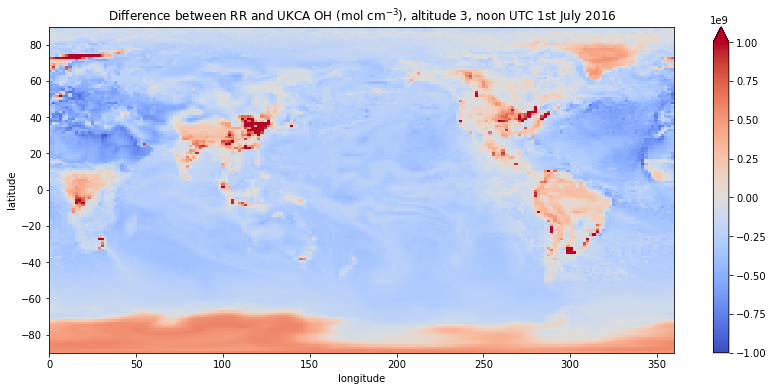

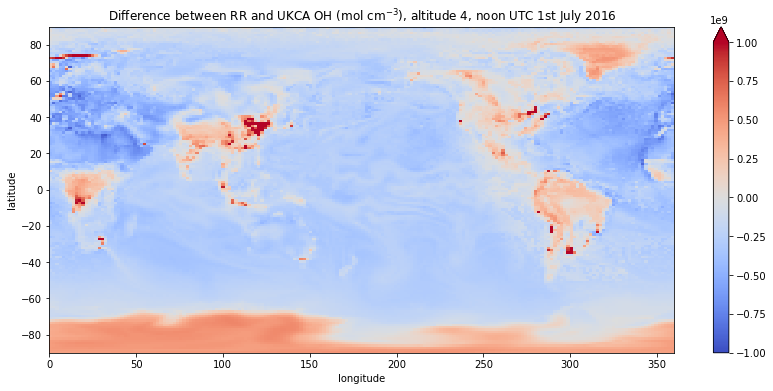

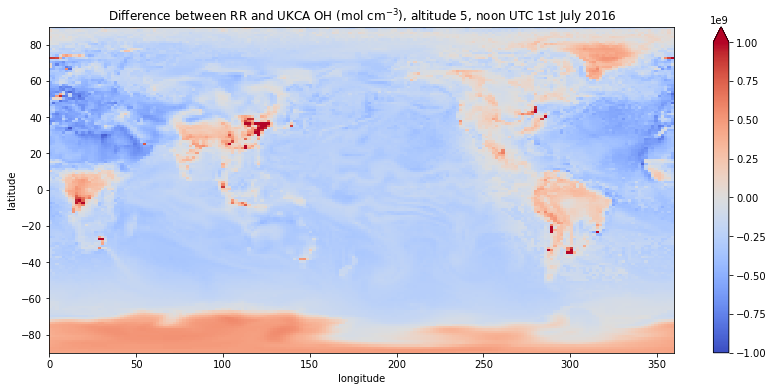

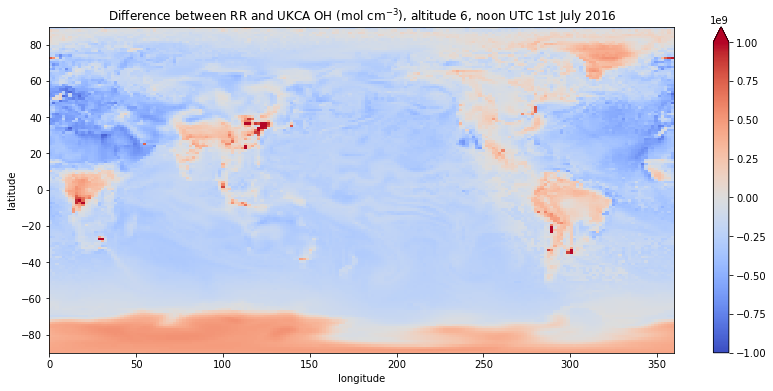

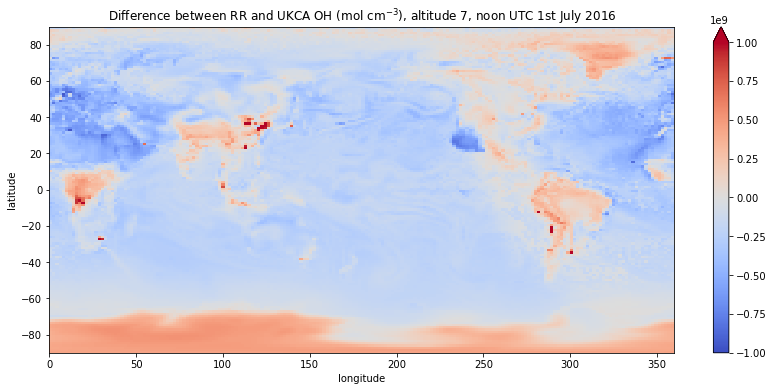

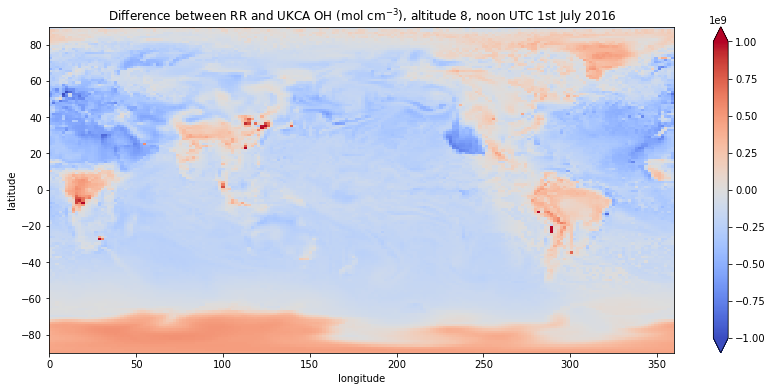

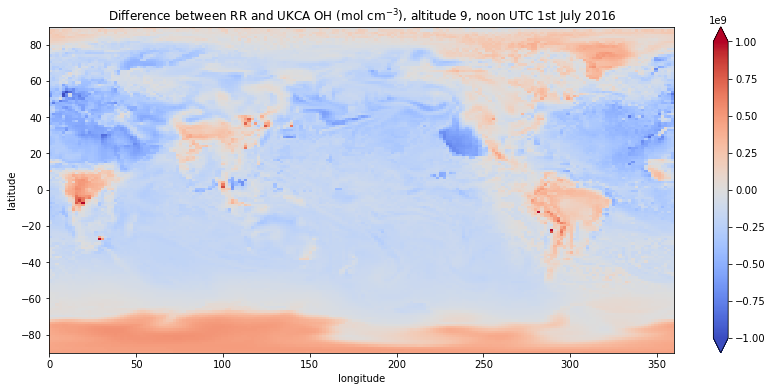

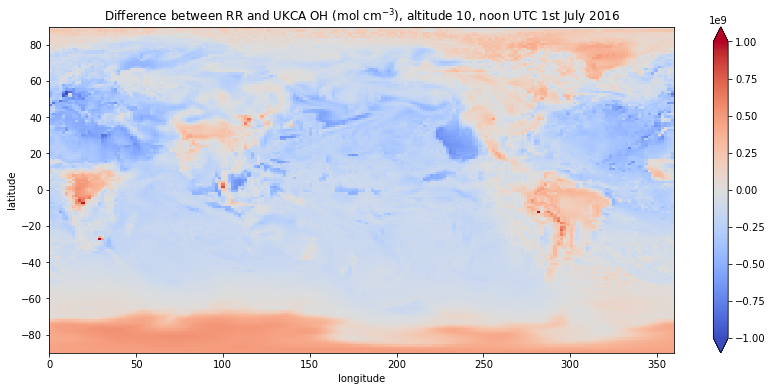

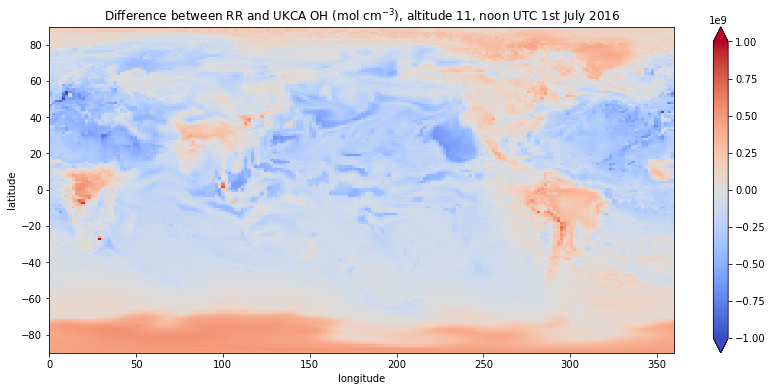

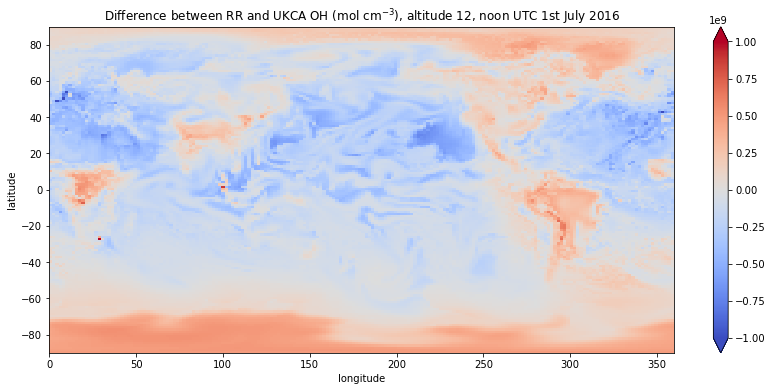

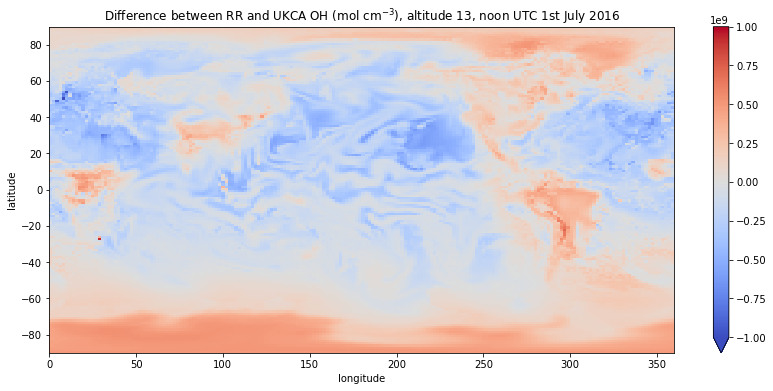

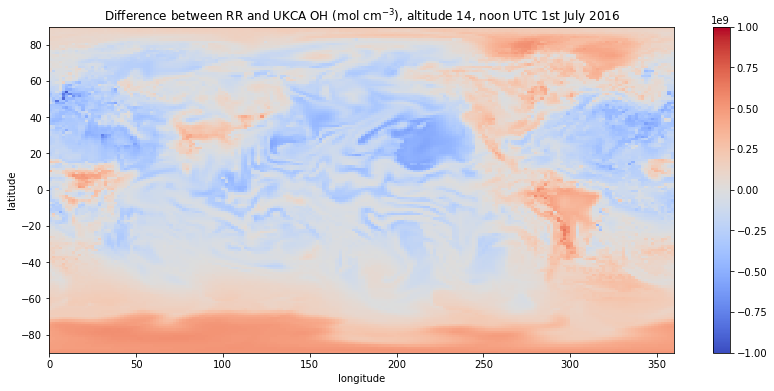

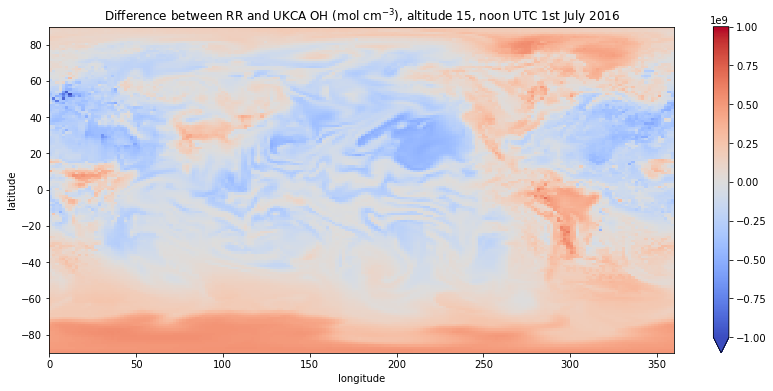

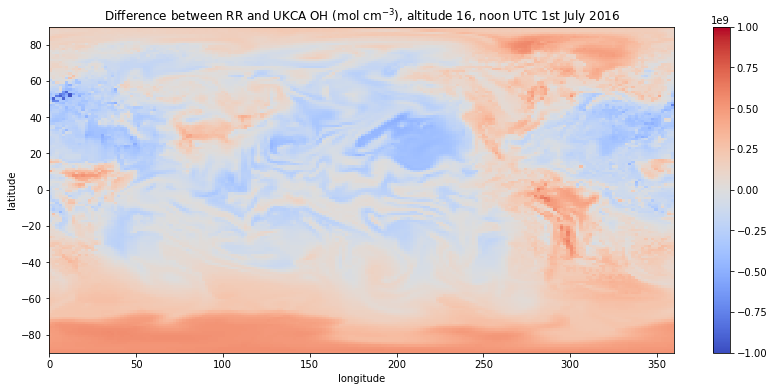

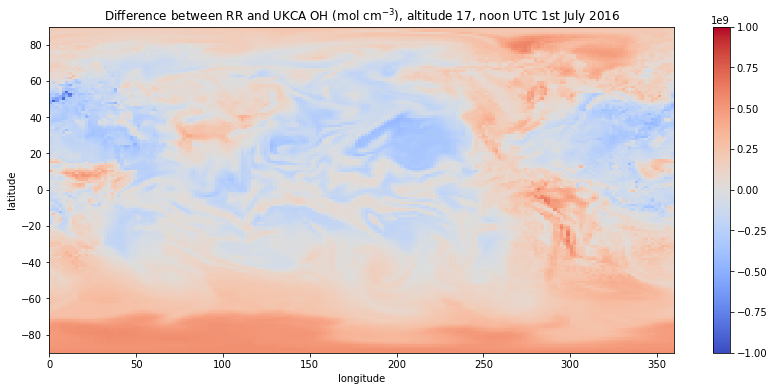

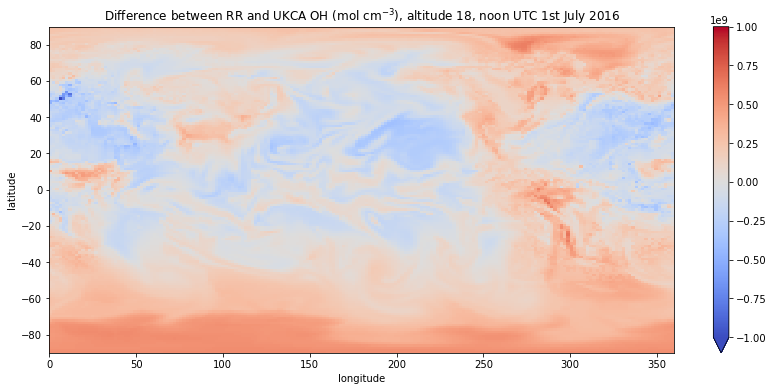

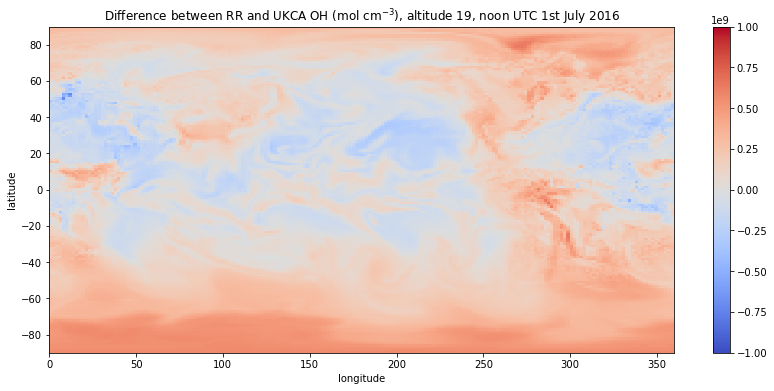

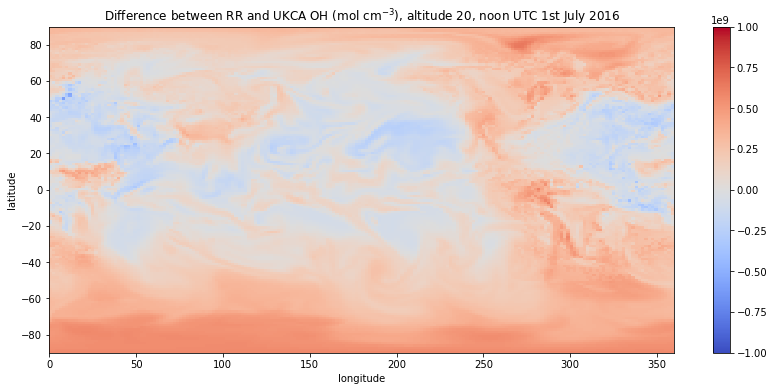

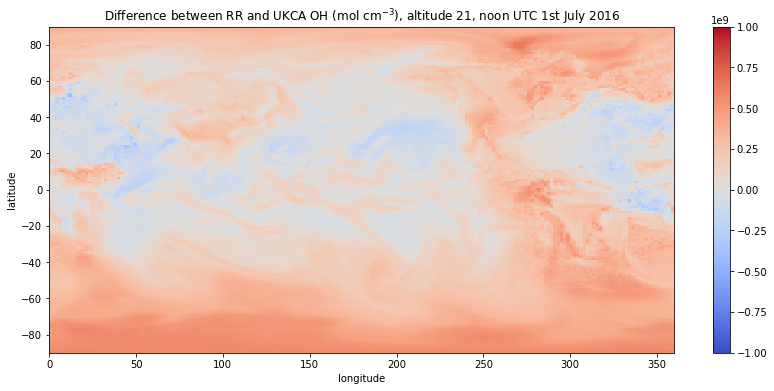

In [334]:
for _ in range(22):
    OH_comparison_dict[_].plot.pcolormesh(figsize=(14,6), robust=True, vmin=-1e9, vmax=1e9, cmap = 'coolwarm')
    plt.title('Difference between RR and UKCA OH (mol cm$^{-3}$), altitude '+str(_)+', noon UTC 1st July 2016')

In [165]:
### Repeat for midnight - careful with this code - you are repeating variables

In [158]:
spec_hum_dict_midnight = {}
for _ in range(0,22):
    spec_hum_dict_midnight[_] = data('10', 'ST_bv941', 0, 1, 0, _)

O3_dict_midnight = {}
for _ in range(0,22):
    O3_dict_midnight[_] = data('34001', 'ST_bv941', 0, 1, 0, _)

NO_dict_midnight = {}
for _ in range(0,22):
    NO_dict_midnight[_] = data('34002', 'ST_bv941', 0, 1, 0, _)

CH4_dict_midnight = {}
for _ in range(0,22):
    CH4_dict_midnight[_] = data('34009', 'ST_bv941', 0, 1, 0, _)

CO_dict_midnight = {}
for _ in range(0,22):
    CO_dict_midnight[_] = data('34010', 'ST_bv941', 0, 1, 0, _)

HCHO_dict_midnight = {}
for _ in range(0,22):
    HCHO_dict_midnight[_] = data('34011', 'ST_bv941', 0, 1, 0, _)

OH_dict_midnight = {}
for _ in range(0,22):
    OH_dict_midnight[_] = data('34081', 'ST_bv941', 0, 1, 0, _)

HO2_dict_midnight = {}
for _ in range(0,22):
    HO2_dict_midnight[_] = data('34082', 'ST_bv941', 0, 1, 0, _)

NO2_dict_midnight = {}
for _ in range(0,22):
    NO2_dict_midnight[_] = data('34996', 'ST_bv941', 0, 1, 0, _)

JO1D_dict_midnight = {}
for _ in range(0,22):
    JO1D_dict_midnight[_] = data('50228', 'ST_bv941', 0, 1, 0, _)

JNO2_dict_midnight = {}
for _ in range(0,22):
    JNO2_dict_midnight[_] = data('50229', 'ST_bv941', 0, 1, 0, _)

P_dict_midnight = {}
for _ in range(0,22):
    P_dict_midnight[_] = data('408', 'ST_bv941', 0, 1, 0, _)

T_dict_midnight = {}
for _ in range(0,22):
    T_dict_midnight[_] = data('16004', 'ST_bv941', 0, 1, 0, _)

In [160]:
stacks_mn = {}
for i in range(0,22):
    stacks_mn[i] = np.dstack((spec_hum_dict_midnight[i],CH4_dict_midnight[i],CO_dict_midnight[i],NO2_dict_midnight[i],
                                    O3_dict_midnight[i],P_dict_midnight[i],T_dict_midnight[i],JO1D_dict_midnight[i],
                                    JNO2_dict_midnight[i]))

In [169]:
stacks_columns_means = {}
stacks_columns_stds = {}
stacks_means = {}
stacks_stds = {}
for _ in range(22):
    stacks_columns_means[_] = stacks_mn[_].mean(axis = 1)
    stacks_columns_stds[_] = stacks_mn[_].std(axis=1)
    stacks_means[_] = stacks_columns_means[_].mean(axis = 0)
    stacks_stds[_] = stacks_columns_stds[_].mean(axis = 0)

In [170]:
stacked_means_mn = np.vstack((stacks_means[0], stacks_means[1], stacks_means[2], stacks_means[3], stacks_means[4], stacks_means[5], 
                           stacks_means[6], stacks_means[7], stacks_means[8], stacks_means[9], stacks_means[10], stacks_means[11], 
                           stacks_means[12], stacks_means[13], stacks_means[14], stacks_means[15], stacks_means[16], stacks_means[17], stacks_means[18],
                           stacks_means[19], stacks_means[20], stacks_means[21]))
stacked_stds_mn = np.vstack((stacks_stds[0], stacks_stds[1], stacks_stds[2], stacks_stds[3], stacks_stds[4], stacks_stds[5], 
                          stacks_stds[6], stacks_stds[7], stacks_stds[8], stacks_stds[9], stacks_stds[10], stacks_stds[11], 
                          stacks_stds[12], stacks_stds[13], stacks_stds[14], stacks_stds[15], stacks_stds[16], stacks_stds[17], 
                          stacks_stds[18], stacks_stds[19], stacks_stds[20], stacks_stds[21]))

In [171]:
OH_column_mean = {}
OH_column_std = {}
OH_means = {}
OH_stds = {}
for _ in range(22):
    OH_column_mean[_] = OH_dict_midnight[_].mean(axis = 1)
    OH_column_std[_] = OH_dict_midnight[_].std(axis=1)
    OH_means[_] = OH_column_mean[_].mean(axis = 0)
    OH_stds[_] = OH_column_std[_].mean(axis = 0)

In [173]:
OH_stacked_means_mn = np.vstack((OH_means[0], OH_means[1], OH_means[2], OH_means[3], OH_means[4], OH_means[5], 
                             OH_means[6], OH_means[7], OH_means[8], OH_means[9], OH_means[10], OH_means[11], 
                             OH_means[12], OH_means[13], OH_means[14], OH_means[15], OH_means[16], OH_means[17], 
                             OH_means[18], OH_means[19], OH_means[20], OH_means[21]))
OH_stacked_stds_mn = np.vstack((OH_stds[0], OH_stds[1], OH_stds[2], OH_stds[3], OH_stds[4], OH_stds[5], 
                             OH_stds[6], OH_stds[7], OH_stds[8], OH_stds[9], OH_stds[10], OH_stds[11], 
                             OH_stds[12], OH_stds[13], OH_stds[14], OH_stds[15], OH_stds[16], OH_stds[17], 
                             OH_stds[18], OH_stds[19], OH_stds[20], OH_stds[21]))

In [174]:
OH_means_over_height = OH_stacked_means.mean(axis=0)
OH_stds_over_height = OH_stacked_stds.mean(axis=0)

In [ ]:
### NOT COMPLETE

In [222]:
### IGNORE BELOW THIS - WORKING

In [211]:
x = np.dstack((spechum_selected_time_height_array, CH4_selected_time_height_array, CO_selected_time_height_array,
              NO2_selected_time_height_array, O3_selected_time_height_array, P_selected_time_height_array,
              T_selected_time_height_array, JO1D_selected_time_height_array, JNO2_selected_time_height_array))

In [65]:
x.shape

(144, 192, 9)

In [61]:
x_columns_mean = x.mean(axis = 1)
x_columns_std = x.std(axis=1)

In [62]:
x_mean = x_columns_mean.mean(axis = 0)
x_std = x_columns_std.mean(axis = 0)

In [64]:
x_mean.shape

(9,)

In [63]:
x_std

array([2.1148110e-03, 1.3265518e-09, 2.5919931e-08, 5.8302807e-10,
       1.5271150e-08, 4.8797651e+03, 4.8050961e+00, 8.3335535e-06,
       2.9766464e-03], dtype=float32)

In [66]:
x_norm = (x - x_mean)/x_std 
x_norm.shape

(144, 192, 9)

In [74]:
preds.shape

(192,)

In [75]:
for _ in range(1,144,1):
    preds_t = rr.predict(x_norm[_,:,:])
    preds = np.vstack([preds, preds_t])

In [76]:
preds.shape

(144, 192)

In [77]:
preds

array([[3.96958658, 3.97697432, 3.98357909, ..., 3.94939503, 3.95519896,
        3.96462173],
       [4.01476718, 4.00343552, 3.99006469, ..., 4.03708059, 4.03047489,
        4.02368425],
       [4.12262456, 4.13623534, 4.14823099, ..., 4.07915499, 4.09483025,
        4.10869969],
       ...,
       [1.2049467 , 1.06178907, 1.05857566, ..., 1.79749557, 0.99951641,
        1.46906581],
       [1.49466026, 1.4765692 , 1.31287218, ..., 1.29374808, 1.17789678,
        1.33886959],
       [1.34804695, 0.93497675, 0.99620917, ..., 0.75709191, 0.88570486,
        0.95498671]])

In [54]:
def df_to_array(df):
    array = df.to_numpy()
    return array

In [55]:
def select_long(df):
    df_long = df.iloc[:,0]
    return df_long

In [56]:
select_long(P_selected_time_height_df)

latitude
-89.375    66178.328125
-88.125    67451.492188
-86.875    68062.578125
-85.625    68187.476562
-84.375    68876.953125
               ...     
 84.375    99070.031250
 85.625    99004.078125
 86.875    98970.765625
 88.125    98957.828125
 89.375    98974.171875
Name: 0.9375, Length: 144, dtype: float32

In [57]:
#H2O_DLH	CH4_NOAA	CO_NOAA	NO2_CL	O3_CL	P	T	jO3_O2_O1D_CAFS	jNO2_NO_O3P_CAFS

In [58]:
spechum_selected_time_height_df_long = select_long(spechum_selected_time_height_df)
CH4_selected_time_height_df_long = select_long(CH4_selected_time_height_df)
CO_selected_time_height_df_long = select_long(CO_selected_time_height_df)
NO2_selected_time_height_df_long = select_long(NO2_selected_time_height_df)
O3_selected_time_height_df_long = select_long(O3_selected_time_height_df)
P_selected_time_height_df_long = select_long(P_selected_time_height_df)
T_selected_time_height_df_long = select_long(T_selected_time_height_df)
JO1D_selected_time_height_df_long = select_long(JO1D_selected_time_height_df)
JNO2_selected_time_height_df_long = select_long(JNO2_selected_time_height_df)
OH_selected_time_height_df_long = select_long(OH_selected_time_height_df)

In [59]:
spechum_selected_time_height_array = df_to_array(spechum_selected_time_height_df)
CH4_selected_time_height_array = df_to_array(CH4_selected_time_height_df)
CO_selected_time_height_array = df_to_array(CO_selected_time_height_df)
NO2_selected_time_height_array = df_to_array(NO2_selected_time_height_df)
O3_selected_time_height_array = df_to_array(O3_selected_time_height_df)
P_selected_time_height_array = df_to_array(P_selected_time_height_df)
T_selected_time_height_array = df_to_array(T_selected_time_height_df)
JO1D_selected_time_height_array = df_to_array(JO1D_selected_time_height_df)
JNO2_selected_time_height_array = df_to_array(JNO2_selected_time_height_df)
OH_selected_time_height_array = df_to_array(OH_selected_time_height_df)

In [67]:
df_features_1_long = pd.concat([spechum_selected_time_height_df_long, CH4_selected_time_height_df_long, CO_selected_time_height_df_long,
         NO2_selected_time_height_df_long, O3_selected_time_height_df_long, P_selected_time_height_df_long, T_selected_time_height_df_long,
         JO1D_selected_time_height_df_long, JNO2_selected_time_height_df_long], axis=1)

In [68]:
df_features_1_long_mean = df_features_1_long.mean()
df_features_1_long_std = df_features_1_long.std()

In [69]:
df_features_1_long_norm = (df_features_1_long - df_features_1_long_mean)/df_features_1_long_std 
df_features_1_long_norm

0.9375    0.9375    0.9375    0.9375    0.9375    0.9375  \
latitude                                                               
-89.375  -1.397315  0.638278 -0.556702 -0.427520 -1.010826 -3.080813   
-88.125  -1.398582  0.714400 -0.557566 -0.427454 -1.084336 -2.944875   
-86.875  -1.400647  0.800466 -0.559612 -0.426715 -1.178730 -2.879628   
-85.625  -1.399993  0.822424 -0.558862 -0.425286 -1.240551 -2.866292   
-84.375  -1.400481  0.857453 -0.554632 -0.423960 -1.322408 -2.792675   
...            ...       ...       ...       ...       ...       ...   
 84.375  -0.664074  0.674211 -0.632698 -0.378480 -0.325490  0.431106   
 85.625  -0.673218  0.710483 -0.641457 -0.362598 -0.330356  0.424064   
 86.875  -0.711691  0.662497 -0.650457 -0.390752 -0.269426  0.420507   
 88.125  -0.693404  0.701933 -0.685839 -0.344711 -0.220212  0.419126   
 89.375  -0.710223  0.577901 -0.711337  0.652225 -0.179896  0.420871   

            0.9375    0.9375    0.9375  
latitude                                
-89.375  -2.615646 -1.056192 -1.435561  
-88.125  -2.724409 -1.056192 -1.435561  
-86.875  -2.825649 -1.056192 -1.435561  
-85.625  -2.811700 -1.056192 -1.435561  
-84.375  -2.835129 -1.056192 -1.435561  
...            ...       ...       ...  
 84.375  -0.451347 -0.529066  0.574641  
 85.625  -0.453361 -0.650551  0.215166  
 86.875  -0.462086 -0.702813  0.102640  
 88.125  -0.457486 -0.701083  0.252327  
 89.375  -0.451495 -0.770305 -0.039274  

[144 rows x 9 columns]

In [70]:
array_features_long_norm = df_features_1_long_norm.to_numpy()

In [71]:
OH_selected_time_height_df_long_mean = OH_selected_time_height_df_long.mean()
OH_selected_time_height_df_long_std = OH_selected_time_height_df_long.std()

In [72]:
OH_1_long_norm = (OH_selected_time_height_df_long - OH_selected_time_height_df_long_mean)/OH_selected_time_height_df_long_std 
OH_1_long_norm

latitude
-89.375   -1.125979
-88.125   -1.125979
-86.875   -1.125980
-85.625   -1.125980
-84.375   -1.125980
             ...   
 84.375   -0.556598
 85.625   -0.619256
 86.875   -0.767895
 88.125   -0.575418
 89.375   -0.289613
Name: 0.9375, Length: 144, dtype: float32

In [192]:
da = xr.DataArray(
    preds,
    coords=[np.linspace(-89.375, 89.375, 144),
        np.linspace(0.9375, 359.0625, 192)],
       dims=("latitude", "longitude"))

In [193]:
da

<xarray.DataArray (latitude: 144, longitude: 192)>
array([[3.96958658, 3.97697432, 3.98357909, ..., 3.94939503, 3.95519896,
        3.96462173],
       [4.01476718, 4.00343552, 3.99006469, ..., 4.03708059, 4.03047489,
        4.02368425],
       [4.12262456, 4.13623534, 4.14823099, ..., 4.07915499, 4.09483025,
        4.10869969],
       ...,
       [1.2049467 , 1.06178907, 1.05857566, ..., 1.79749557, 0.99951641,
        1.46906581],
       [1.49466026, 1.4765692 , 1.31287218, ..., 1.29374808, 1.17789678,
        1.33886959],
       [1.34804695, 0.93497675, 0.99620917, ..., 0.75709191, 0.88570486,
        0.95498671]])
Coordinates:
  * latitude   (latitude) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1

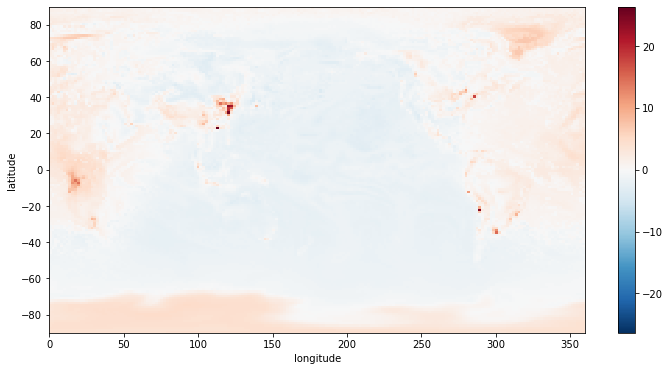

In [194]:
da.plot(figsize=(12,6))

In [108]:
preds_dataarray = xr.DataArray(preds, coords=[])

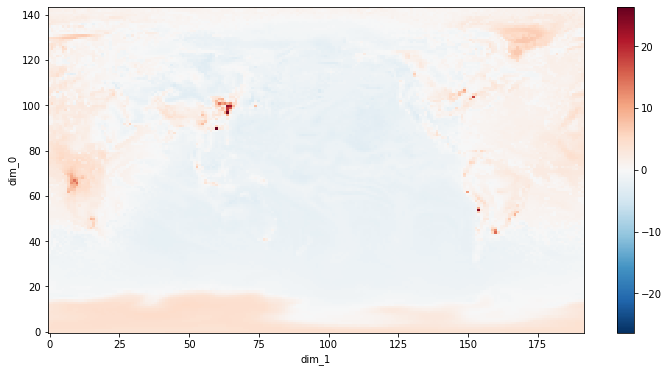

In [109]:
preds_dataarray.plot(figsize=(12,6))

### THE CELL ABOVE HAS THE CORRECT PREDICTIONS OF OH FOR A SINGLE TIME AND HEIGHT
### TO BE COMPARED TOMORROW - WITH MODEL VALUES
### DON'T FORGET TO UNNORMALISE

In [78]:
predictions3 = rr.predict(x_norm[0,:,:])
predictions3

array([3.96958658, 3.97697432, 3.98357909, 3.98988138, 3.99626227,
       4.00235542, 4.00799156, 4.01283275, 4.01944416, 4.02528017,
       4.03025437, 4.03485386, 4.03814997, 4.04272883, 4.04784403,
       4.0509305 , 4.0528686 , 4.05414796, 4.05680239, 4.0616606 ,
       4.06184023, 4.05967814, 4.06111457, 4.06359562, 4.06853169,
       4.06953842, 4.07262264, 4.07385072, 4.07500908, 4.07763493,
       4.08077365, 4.08411259, 4.08845706, 4.09321706, 4.09793446,
       4.10143341, 4.10484144, 4.10977204, 4.11253411, 4.11616937,
       4.11770254, 4.12036966, 4.12256892, 4.12608775, 4.12890816,
       4.13022445, 4.13448546, 4.13927912, 4.13882073, 4.14382009,
       4.14912236, 4.1507475 , 4.15630135, 4.16172263, 4.16467913,
       4.17059303, 4.1770877 , 4.18439269, 4.18931249, 4.19707225,
       4.20448132, 4.21534707, 4.2242104 , 4.23276401, 4.24095416,
       4.24993084, 4.25985839, 4.26826804, 4.27698333, 4.28525308,
       4.28711062, 4.29103708, 4.29605375, 4.29953665, 4.29588

In [79]:
predictions2 = rr.predict(array_features_long_norm)
predictions2

array([ 0.14947823,  0.12865409,  0.14248835,  0.13656573,  0.11335518,
        0.03115347, -0.07758108, -0.08426137, -0.03415021, -0.00934786,
        0.00922835,  0.1013339 ,  0.09800049, -0.27189747, -0.950726  ,
       -1.58242623, -1.677901  , -1.65807231, -1.56240435, -1.49268304,
       -1.46153778, -1.45419312, -1.4734119 , -1.43936572, -1.37264366,
       -1.42786234, -1.46790975, -1.48968958, -1.54208571, -1.54989073,
       -1.52068694, -1.52306038, -1.60278744, -1.60655738, -1.55540747,
       -1.04055771, -1.1775692 , -1.46757416, -1.2583427 , -1.21376102,
       -1.11146359, -1.0425092 , -0.70455483, -0.67427408, -0.71655466,
       -1.04075646, -1.06861051, -1.06908509, -0.46980527, -0.41912921,
       -0.31590964, -0.16855806, -0.12423853, -0.18616981, -0.21779173,
       -0.19375074, -0.32539187, -0.81456848, -0.5513346 , -0.043645  ,
       -0.05710606, -0.01498448, -0.03898154, -0.21822919,  0.30907881,
       -0.03534515,  0.48844318,  0.2740851 ,  0.39215889,  0.72

In [80]:
predictions = rr.predict(df_features_1_long_norm)
predictions

array([ 0.14947823,  0.12865409,  0.14248835,  0.13656573,  0.11335518,
        0.03115347, -0.07758108, -0.08426137, -0.03415021, -0.00934786,
        0.00922835,  0.1013339 ,  0.09800049, -0.27189747, -0.950726  ,
       -1.58242623, -1.677901  , -1.65807231, -1.56240435, -1.49268304,
       -1.46153778, -1.45419312, -1.4734119 , -1.43936572, -1.37264366,
       -1.42786234, -1.46790975, -1.48968958, -1.54208571, -1.54989073,
       -1.52068694, -1.52306038, -1.60278744, -1.60655738, -1.55540747,
       -1.04055771, -1.1775692 , -1.46757416, -1.2583427 , -1.21376102,
       -1.11146359, -1.0425092 , -0.70455483, -0.67427408, -0.71655466,
       -1.04075646, -1.06861051, -1.06908509, -0.46980527, -0.41912921,
       -0.31590964, -0.16855806, -0.12423853, -0.18616981, -0.21779173,
       -0.19375074, -0.32539187, -0.81456848, -0.5513346 , -0.043645  ,
       -0.05710606, -0.01498448, -0.03898154, -0.21822919,  0.30907881,
       -0.03534515,  0.48844318,  0.2740851 ,  0.39215889,  0.72

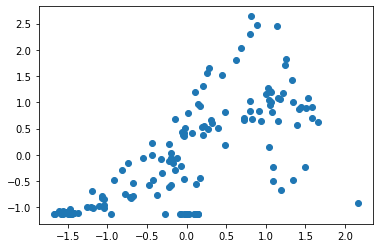

In [81]:
plt.scatter(predictions, OH_1_long_norm)

In [82]:
OH_selected_time = OH.sel(time='2016-07-01T12:00:00.000000000')
OH_selected_time

<xarray.DataArray 'UM_m01s34i081_vn1105' (atmosphere_hybrid_height_coordinate: 52, latitude: 144, longitude: 192)>
[1437696 values with dtype=float32]
Coordinates:
    time                                 datetime64[ns] 2016-07-01T12:00:00
  * longitude                            (longitude) float64 0.9375 ... 359.1
  * latitude                             (latitude) float64 -89.38 ... 89.38
  * atmosphere_hybrid_height_coordinate  (atmosphere_hybrid_height_coordinate) float64 ...
Attributes:
    long_name:     OH MASS MIXING RATIO AFTER TIMESTEP
    units:         1
    cell_methods:  time: point

In [83]:
OH_selected_time_height = OH_selected_time.isel(atmosphere_hybrid_height_coordinate=3) 
OH_selected_time_height

<xarray.DataArray 'UM_m01s34i081_vn1105' (latitude: 144, longitude: 192)>
array([[2.788522e-19, 2.780982e-19, 2.774306e-19, ..., 2.807116e-19,
        2.802415e-19, 2.792325e-19],
       [2.433218e-19, 2.470959e-19, 2.513403e-19, ..., 2.350719e-19,
        2.375061e-19, 2.401105e-19],
       [2.021011e-19, 2.023604e-19, 2.029639e-19, ..., 2.019803e-19,
        2.017659e-19, 2.019008e-19],
       ...,
       [3.880877e-14, 4.110490e-14, 4.163293e-14, ..., 4.105004e-14,
        3.294261e-14, 3.935395e-14],
       [5.966918e-14, 5.940704e-14, 8.161053e-14, ..., 3.659724e-14,
        4.673047e-14, 6.072355e-14],
       [9.064415e-14, 8.554958e-14, 1.075688e-13, ..., 8.396360e-14,
        7.584303e-14, 7.630662e-14]], dtype=float32)
Coordinates:
    time                                 datetime64[ns] 2016-07-01T12:00:00
  * longitude                            (longitude) float64 0.9375 ... 359.1
  * latitude                             (latitude) float64 -89.38 ... 89.38
    atmosphere_hybrid_height_coordinate  float64 0.008368
Attributes:
    long_name:     OH MASS MIXING RATIO AFTER TIMESTEP
    units:         1
    cell_methods:  time: point

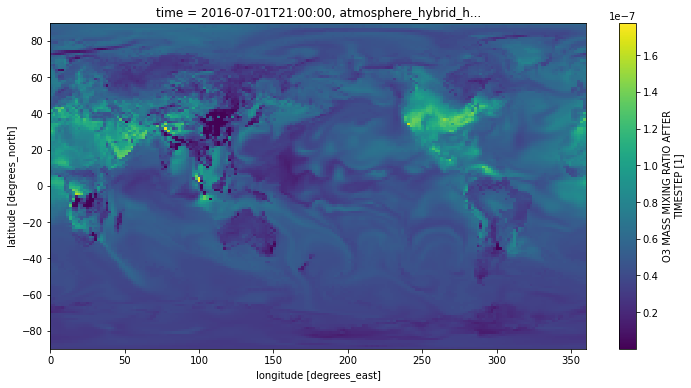

In [203]:
O3.isel(time=20, atmosphere_hybrid_height_coordinate=0).plot(figsize=(12,6))

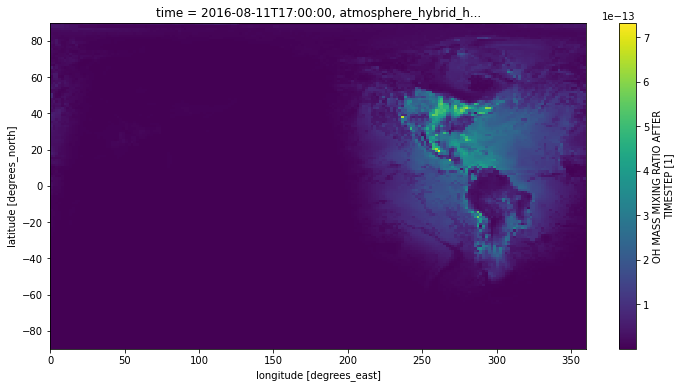

In [87]:
OH.isel(time=1000, atmosphere_hybrid_height_coordinate=5).plot(figsize=(12,6))

In [88]:
O3.isel(longitude=1, latitude=2)

<xarray.DataArray 'UM_m01s34i001_vn1105' (time: 1488, atmosphere_hybrid_height_coordinate: 52)>
array([[3.182178e-08, 3.395360e-08, 3.433253e-08, ..., 5.197199e-06,
        5.614304e-06, 5.714295e-06],
       [3.176507e-08, 3.389180e-08, 3.428442e-08, ..., 5.200026e-06,
        5.615099e-06, 5.713745e-06],
       [3.164409e-08, 3.376337e-08, 3.416073e-08, ..., 5.202750e-06,
        5.616095e-06, 5.713217e-06],
       ...,
       [3.618943e-08, 3.856313e-08, 3.871333e-08, ..., 5.155051e-06,
        5.310748e-06, 5.298882e-06],
       [3.618194e-08, 3.855687e-08, 3.871513e-08, ..., 5.151572e-06,
        5.305551e-06, 5.288938e-06],
       [3.613975e-08, 3.851394e-08, 3.868004e-08, ..., 5.147222e-06,
        5.299805e-06, 5.277144e-06]], dtype=float32)
Coordinates:
  * time                                 (time) datetime64[ns] 2016-07-01T01:...
    longitude                            float64 2.812
    latitude                             float64 -86.88
  * atmosphere_hybrid_height_coordinate  (atmosphere_hybrid_height_coordinate) float64 ...
Attributes:
    long_name:     O3 MASS MIXING RATIO AFTER TIMESTEP
    units:         1
    cell_methods:  time: point

## Pump climate model data through my ridge regression

# Read in ATom flight data, isolate latitude, longitude and altitude

In [89]:
uninterpolated_atom1_data = pd.read_csv('/home/shmh4/Downloads/non_interpolated_atom')

/home/shmh4/.conda/envs/netcdf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,7,535,593) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [90]:
uninterpolated_atom1_data

Unnamed: 0             UTC_Start_dt  Start_UTC   Stop_UTC   Mid_UTC  \
0                0  2016-07-29 14:32:49.000    52369.0    52398.0   52384.0   
1                1  2016-07-29 14:32:49.500    52369.0    52398.0   52384.0   
2                2  2016-07-29 14:32:50.000    52369.0    52398.0   52384.0   
3                3  2016-07-29 14:32:50.500    52369.0    52398.0   52384.0   
4                4  2016-07-29 14:32:51.000    52369.0    52398.0   52384.0   
...            ...                      ...        ...        ...       ...   
657752      657752                      NaN        NaN        NaN       NaN   
657753      657753                      NaN        NaN        NaN       NaN   
657754      657754                      NaN        NaN        NaN       NaN   
657755      657755                      NaN        NaN        NaN       NaN   
657756      657756                      NaN        NaN        NaN       NaN   

         OH_ATHOS   HO2_ATHOS       UTC_Start_dt.1         UTC_Start_dt.1.1  \
0             NaN         NaN  2016-07-29 14:32:49  2016-07-29 14:33:17.000   
1             NaN         NaN  2016-07-29 14:32:49  2016-07-29 14:33:17.500   
2             NaN         NaN  2016-07-29 14:32:49  2016-07-29 14:33:18.000   
3             NaN         NaN  2016-07-29 14:32:49  2016-07-29 14:33:18.500   
4             NaN         NaN  2016-07-29 14:32:49  2016-07-29 14:33:19.000   
...           ...         ...                  ...                      ...   
657752        NaN         NaN                  NaN  2016-08-23 20:00:39.000   
657753        NaN         NaN                  NaN  2016-08-23 20:00:39.500   
657754        NaN         NaN                  NaN  2016-08-23 20:00:40.000   
657755        NaN         NaN                  NaN  2016-08-23 20:00:40.500   
657756        NaN         NaN                  NaN  2016-08-23 20:00:41.000   

        UTC_Start  ...  MVK_TOGA  CH3OH_TOGA  C2H5OH_TOGA  MTBE_TOGA  \
0         52397.0  ...     177.4      6930.0       4408.5        NaN   
1         52397.0  ...     177.4      6930.0       4408.5        NaN   
2         52398.0  ...     177.4      6930.0       4408.5        NaN   
3         52398.0  ...     177.4      6930.0       4408.5        NaN   
4         52399.0  ...     177.4      6930.0       4408.5        NaN   
...           ...  ...       ...         ...          ...        ...   
657752    72039.0  ...       NaN         NaN          NaN        NaN   
657753    72039.0  ...       NaN         NaN          NaN        NaN   
657754    72040.0  ...       NaN         NaN          NaN        NaN   
657755    72040.0  ...       NaN         NaN          NaN        NaN   
657756    72041.0  ...       NaN         NaN          NaN        NaN   

        DMS_TOGA  HCN_TOGA  CH3CN_TOGA  EthONO2_TOGA  iPropONO2_TOGA  \
0            NaN     654.0       495.0           NaN            7.12   
1            NaN     654.0       495.0           NaN            7.12   
2            NaN     654.0       495.0           NaN            7.12   
3            NaN     654.0       495.0           NaN            7.12   
4            NaN     654.0       495.0           NaN            7.12   
...          ...       ...         ...           ...             ...   
657752       NaN       NaN         NaN           NaN             NaN   
657753       NaN       NaN         NaN           NaN             NaN   
657754       NaN       NaN         NaN           NaN             NaN   
657755       NaN       NaN         NaN           NaN             NaN   
657756       NaN       NaN         NaN           NaN             NaN   

           UTC_Start_dt.1.3  
0       2016-07-29 14:36:05  
1       2016-07-29 14:36:05  
2       2016-07-29 14:36:05  
3       2016-07-29 14:36:05  
4       2016-07-29 14:36:05  
...                     ...  
657752                  NaN  
657753                  NaN  
657754                  NaN  
657755                  NaN  
657756                  NaN  

[657757 rows x 594 

In [91]:
atom1_careful_data = uninterpolated_atom1_data.iloc[np.r_[0:289000, 313000:657757]]

In [92]:
def df_to_array(variable):
    temp = atom1_careful_data[variable]
    temp = np.array(temp)
    return temp

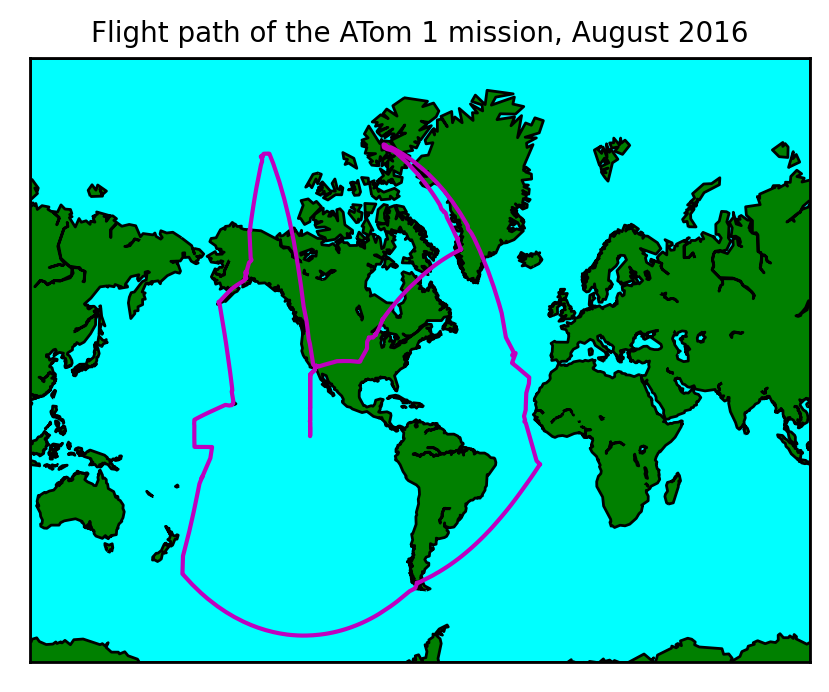

In [93]:
plt.figure(dpi=200)

map = Basemap(llcrnrlon=-250.,llcrnrlat=-70.,urcrnrlon=110.,urcrnrlat=85.,projection='merc')

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='green',lake_color='aqua')
map.drawcoastlines()

x,y = map(df_to_array('G_LONG'), df_to_array('G_LAT'))

map.plot(x, y, marker=None,color='m')
plt.title('Flight path of the ATom 1 mission, August 2016', fontsize = 10)
plt.show()

In [94]:
atom1_longitudes = uninterpolated_atom1_data['G_LONG']+180
atom1_latitudes = uninterpolated_atom1_data['G_LAT']
atom1_altitudes = uninterpolated_atom1_data['G_ALT']
atom1_dates_and_times = uninterpolated_atom1_data['UTC_Start_dt.1.1']

In [95]:
atom1_dates_and_times

0         2016-07-29 14:33:17.000
1         2016-07-29 14:33:17.500
2         2016-07-29 14:33:18.000
3         2016-07-29 14:33:18.500
4         2016-07-29 14:33:19.000
                   ...           
657752    2016-08-23 20:00:39.000
657753    2016-08-23 20:00:39.500
657754    2016-08-23 20:00:40.000
657755    2016-08-23 20:00:40.500
657756    2016-08-23 20:00:41.000
Name: UTC_Start_dt.1.1, Length: 657757, dtype: object

In [96]:
atom1_location = pd.DataFrame({'G_LONG': atom1_longitudes, 'G_LAT': atom1_latitudes, 'G_ALT': atom1_altitudes})

In [97]:
atom1_location

G_LONG     G_LAT  G_ALT
0       61.89369  34.63100  795.5
1       61.89369  34.63100  795.5
2       61.89265  34.63096  799.3
3       61.89265  34.63096  799.3
4       61.89161  34.63092  803.8
...          ...       ...    ...
657752  61.90453  34.63161  790.2
657753  61.90453  34.63161  790.2
657754  61.90396  34.63157  790.5
657755  61.90396  34.63157  790.5
657756  61.90341  34.63155  790.7

[657757 rows x 3 columns]

In [98]:
atom1_location_array = np.array(atom1_location)

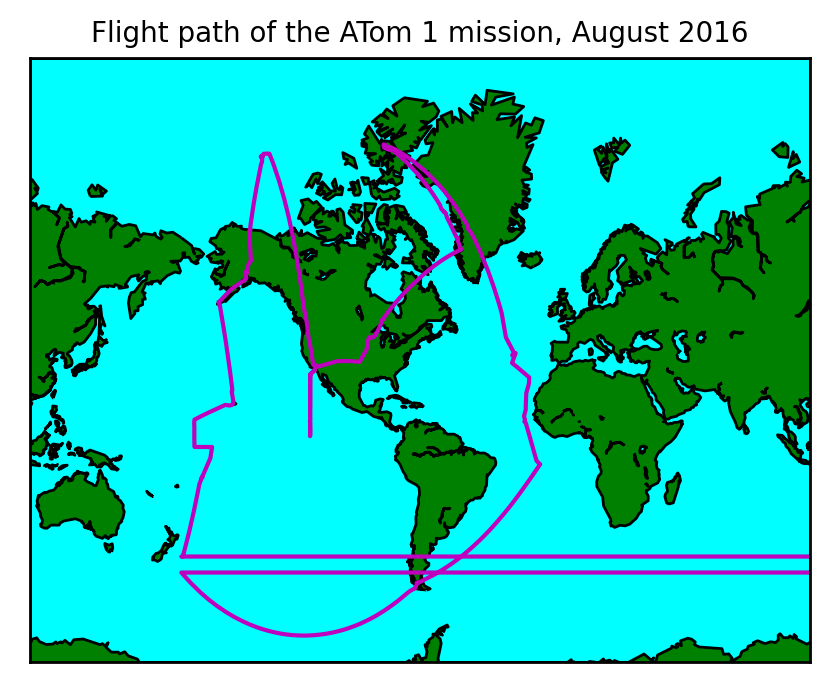

In [99]:
plt.figure(dpi=200)

map = Basemap(llcrnrlon=-250.,llcrnrlat=-70.,urcrnrlon=110.,urcrnrlat=85.,projection='merc')

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='green',lake_color='aqua')
map.drawcoastlines()

x,y = map(atom1_location_array[:,0]-180, atom1_location_array[:,1])

map.plot(x, y, marker=None,color='m')
plt.title('Flight path of the ATom 1 mission, August 2016', fontsize = 10)
plt.show()

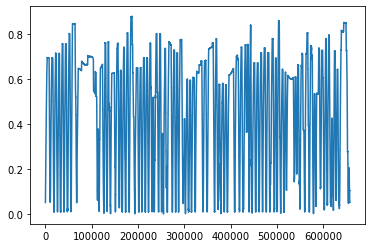

In [100]:
plt.plot(atom1_altitudes/15000) # Potentially this is what we want - how high is 52 levels?? To ask James.

# Can only make this work for sea - goes wrong if I try land
## Something about ap and b

In [101]:
def lat_and_lon_and_altitude(lat_value, lon_value, form, 
                             altitude_opt, altitude_select, date_and_time):
    '''
    Provided with a latitude and longitude, this function returns the indices for the 
    model lat and lon arrays.
    
    Specify form = 'dd' or model ='dms' for decimal degrees, degrees-minutes-seconds respectively
    
    Note - provide inputs as strings, e.g. for dms "26_3_12" = 26° 3' 12''
    
    Two versions of altitude - sea-level and above land (use one or other) - either give the function altitude above land or altitude above sea-level
    
    If altitude_opt='sea', the function will output the index of the model level 
    with centre closest to supplied altitude assuming that altitude is height above sea-level.  
    
    If altitude_opt='land', the function will output the index of the model level 
    with centre closest to supplied altitude assuming that altitude is height above land. 
    
    For the optional altitude section to work you need to have the array
    actual_altitude_above_sea_level_N96L85 . 
    '''
    
    model_lon_centre = np.linspace(0.9375,359.0625,192)
    model_lat_centre = np.linspace(-89.375,89.375,144)

 

    # convert dms to dd
    if form == 'dms':
        lat=lat_value.split('_')
        lon=lon_value.split('_')
        
        lat_deg, lat_min, lat_sec = float(lat[0]), float(lat[1]), float(lat[2])
        lon_deg, lon_min, lon_sec = float(lon[0]), float(lon[1]), float(lon[2])
        
        lat_value = lat_deg + lat_min/60 + lat_sec/3600
        
        lon_value = lon_deg + lon_min/60 + lon_sec/3600
    
        print(lat_value, lon_value)
    
    
    if form == 'dd':
        lat_value=lat_value
        lon_value=lon_value
        
    lat_index=(np.abs(model_lat_centre-lat_value)).argmin()
    lon_index=(np.abs(model_lon_centre-lon_value)).argmin()
    
    
    if altitude_opt in ['sea','land']:
        # any nc file with multiple vertical levels should do
        model_base='/home/shmh4/CAS_paper/' 
        data=nc.Dataset(model_base+'volume_1month.nc')       
        ap=data.variables['atmosphere_hybrid_height_coordinate'][:]
        b=data.variables['atmosphere_hybrid_height_coordinate'][:]
        
        alt_base = '/home/shmh4/CAS_paper/'
        alt_above_sea_level = np.load(alt_base+'actual_altitude_above_sea_level_N96L85.npy')
        
        # orography is height of the land surface rather than sea-level
        orography = (alt_above_sea_level[0,:,:] - ap[0])/b[0]
    
    
    if altitude_opt == 'sea': #supplying altitude above sea level (regardless of whether grid cell is above land or sea)
        
        model_level_alt = alt_above_sea_level[:,lat_index, lon_index]
        
        alt_index = (np.abs(model_level_alt-altitude_select)).argmin()
    
        return lat_index, lon_index, alt_index, date_and_time
    
    elif altitude_opt == 'land': #supplying altitude above land 
        # if supplying altitude above land, need add in height of land i.e. orography
        model_level_alt = alt_above_sea_level[:,lat_index, lon_index]
        altitude_select = altitude_select + orography[lat_index, lon_index]
        
        alt_index = (np.abs(model_level_alt-altitude_select)).argmin()
        
        return lat_index, lon_index, alt_index, date_and_time
    else:
        return lat_index, lon_index

In [102]:
lat_and_lon_and_altitude(0, 360, 'dd', 'sea', 87, atom1_dates_and_times[1])

(71, 191, 2, '2016-07-29 14:33:17.500')

In [103]:
empty_list = []

In [104]:
for i in np.arange(0,657756,100):
    a = lat_and_lon_and_altitude(atom1_latitudes[i], atom1_longitudes[i], 'dd', 'sea', atom1_altitudes[i], atom1_dates_and_times[i])
    empty_list.append(a)
    

KeyboardInterrupt: 

In [ ]:
empty_list

In [ ]:
df_plane_locations = pd.DataFrame(empty_list)
df_plane_locations.columns = ['Lat','Long','Alt', 'Dates']
df_plane_locations

In [ ]:
long_array = df_plane_locations['Long'].to_numpy()
lat_array = df_plane_locations['Lat'].to_numpy()

In [ ]:
long_array

In [ ]:
lat_array

In [ ]:
plt.figure(dpi=200)

map = Basemap(llcrnrlon=-250.,llcrnrlat=-70.,urcrnrlon=110.,urcrnrlat=85.,projection='merc')

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='green',lake_color='aqua')
map.drawcoastlines()

x,y = map(long_array-180, lat_array-90)

map.plot(x, y, marker=None,color='m')
plt.title('Flight path of the ATom 1 mission, August 2016', fontsize = 10)
plt.show()

# Some nonsense checking what this netcdf looks like

In [ ]:
check_data = xr.open_dataset("/home/shmh4/CAS_paper/volume_1month.nc")

In [ ]:
check_data